# The LFC Goal Machine (R version)

This python3 notebook analyses Liverpool FC's goal scorers, in particular exploring a scatter plot of a player's top level league goals scored in a season against the age of the player at the mid-point of that season. The plot is available as an interactive web app called the LFC Goal Machine [here](https://terrydolan.shinyapps.io/lfcgmR/). 

The notebook generates and validates the required data (based on reference data from lfchistory.net) and prototypes the key parts of the R application. Python is used for the data preparation and analysis, and R is used for the interactive application and plotting. The application's core plotting function uses R's ggplot2.

The notebook contains the key algorithms, some interesting LFC player plots and describes how the lfcgmR app is built and deployed.

The project uses [Anaconda](https://www.anaconda.com/), [Jupyter Notebook](http://jupyter.org/), [Python](https://www.python.org/), [Pandas](http://pandas.pydata.org/), [rpy2](https://rpy2.readthedocs.io/), [R](https://www.r-project.org/), [R ggplot](http://ggplot2.org/), [R studio](https://www.rstudio.com/), [R shiny](http://shiny.rstudio.com/), [R dplyr](https://cran.r-project.org/web/packages/dplyr/index.html), [R scales](https://cran.r-project.org/web/packages/scales/index.html), [R stringr](https://cran.r-project.org/web/packages/stringr/index.html).

__Application History and Change of Approach at August 2019__

The original lfcgm interactive application (built around 2016) was contained a shared core plotting function and was deployed as both a Python app (using Spyre and Heroku) and an R app (using RStudio). Both of these versions had ggplot at their core; with the R implementation using ggplot2 and the python implementation using yhat 'port' of ggplot2. The R ggplot implementation is excellent and the original objective was always to have the core plotting algorithm defined in ggplot.

The original python app used yhat's ggplot. The yhat ggplot developer has taken the decision to not to continue to R-like version for python. The latest version of yhat's ggplot is 'work in progress'. There are several other ggplot-like developments that are also available in python. All of these projects aim to be pythonic thereby making it difficult to maintain a single core function based on ggplot that can be shared between python and R. 

Also, R Studio makes it very easy to develop and deploy interactive web apps. The nearest equivalent in python in 2016 was Spyre in conjunction with Heroku. Spyre is no longer developed. [Ed: streamlit coming up on the rails @Oct 2020.]

Therefore I've decided to maintain only the R version of the lfcgm app. However, this remains a hybrid Python and R development. Python infrastructure (Pandas, etc) is used to generate and validate the required data, and explore the core plotting function. The Python rpy2 library is used to run R commands in a python3 notebook.

## Notebook Approach

This python3 notebook prepares and validates the data and algorithms for the LFC Goal Machine app (lfcgmR). 

1. Load the input data files, enhance (e.g. add player age at season midpoint) and generate the required lfcgmR application data. The application requires 2 csvs:
 - data/lfc_scorers_tl_pos_age.csv: containing all of the LFC scorers in the top flight seasons with their age.
 - data/lfcgm_app_dropdown.csv: containing a dropdown list of those scorers.

1. Validate the generated data.

1. Validate the core R plotting algorithm (using R's ggplot2).

1. Describe the lfcgmR app, with a link to the github source code.

The lfcgmR app is available as an interactive web app [here](https://terrydolan.shinyapps.io/lfcgmR/). 

### Notebook Change Log

In [1]:
%%html
<! left align the change log table in next cell >
<style>
table {float:left}
</style>

| Date          | Change Description |
| :------------- | :----------------- |
| 21st February 2016 | Initial python and r baseline versions|
| 30th October 2016 | Added LFC season 2015-16 |
| 12th October 2017 | Added LFC season 2016-17 |
| 31st August 2019 | Added LFC seasons 2017-18 and 2018-19; Moved to Python 3; restuctured the application to focus on R version; updated function to generate age at midpoint of season; improved the data validation; enhanced R app to: improve core plotting function, especially y axis ints; add table tab to show the data table |
| 20th October 2020 | Added LFC season 2019-20; udated ggplot_age_vs_lgoals() to add title 19 (!); ; changed example plot to use top goalscorers in league title winning seasons; improved title wrapping; worked around several issues with py2r and pandas|

To Do
- Review latest R Studio UI presentation and controls to see if application can be improved.

- Consider extending app to also allow sort by season(s) rather than age; allow overlapping seasons?

- Produce a streamlit version; if ok consider moving back to all python env (with matplotlib based graphing?)

## Set-Up

### Import the python modules needed for the analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import dateutil as du
import dateutil.relativedelta as dr
import datetime as dt
import sys
import os

# enable inline plotting
%matplotlib inline

# fixed issue with rpy2 compatibility with pandas by pip installing latest version of rpy2 (3.3.6)
# this resulted in rpy2 issue:
# "OSError: cannot load library 'C:\Users\Terry\Anaconda3\envs\py37r\lib\R\bin\x64\R.dll': error 0x7e"
# workaround is here: 
# https://stackoverflow.com/questions/63863449/oserror-cannot-load-library-c-program-files-r-r-4-0-2-bin-x64-r-dll-error-0
# add required env variables (hopefully a temprary solution!)
os.environ["R_HOME"] = os.getenv('CONDA_PREFIX') + r"\Lib\R"
os.environ["PATH"]   = os.getenv('CONDA_PREFIX') + r"\Lib\R\bin\x64" + ";" + os.environ["PATH"]


# activate the rpy capability so that R commands can be run in this notebook
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2

# load the extension for the %%R cell magic
%load_ext rpy2.ipython

C:\Users\Terry\Anaconda3\envs\py37r\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


Print key module version numbers.

In [3]:
print('python version: {}'.format(sys.version))
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('dateutil version: {}'.format(du.__version__))
print('rpy2 version: {}'.format(rpy2.__version__))

python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.1.3
numpy version: 1.19.1
matplotlib version: 3.3.1
dateutil version: 2.8.1
rpy2 version: 3.3.6


In [4]:
# define start time, used to calulate run tikme of notebook
nb_start_time = dt.datetime.now()

### Environment

This notebook uses an Anaconda py37r environment.

In [5]:
# check environment
assert os.environ['CONDA_DEFAULT_ENV'] == 'py37r'

In [6]:
!Python --version

Python 3.7.9


In [7]:
!R --version

R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



## Prepare The Data Files

### Define name and location of csv data files

In [8]:
# define key seasons
LG_SEASON_START = '1893-1894' # first league season (2nd Division)
SEASON_START = '1892-1893' # first season in existance
# modify the following, as required
SEASON_END = '2019-2020' # most recent season
PLAYERS_CSV_MONTH = 'September' # month of players csv extract
PLAYERS_CSV_YEAR = '2020' # year of players csv extract
NUMBER_OF_SEASONS = 105 # 104 in 2019-2020

# define input csv files
print('\nLocation of the input csv data files:')

# define scorers CSV file name (and check exists)
SCORERS_PREFIX = 'lfc_scorers'
SCORERS_CSV_FILE = '{}_{}_{}.csv'.format(SCORERS_PREFIX, SEASON_START, SEASON_END)
LFC_SCORERS_CSV_FILE = os.path.relpath('data/{}'.format(SCORERS_CSV_FILE))
assert os.path.isfile(LFC_SCORERS_CSV_FILE) 
print('LFC scorers csv file is: {}'.format(LFC_SCORERS_CSV_FILE))

# define squads CSV file name (and check exists)
SQUADS_PREFIX = 'lfc_squads'
SQUADS_CSV_FILE = '{}_{}_{}.csv'.format(SQUADS_PREFIX, SEASON_START, SEASON_END)
LFC_SQUADS_CSV_FILE = os.path.relpath('data/{}'.format(SQUADS_CSV_FILE))
assert os.path.isfile(LFC_SQUADS_CSV_FILE) 
print('LFC squads csv file is: {}'.format(LFC_SQUADS_CSV_FILE))

# define player appearances CSV file name (and check exists)
APPS_PREFIX = 'lfc_apps'
APPS_CSV_FILE = '{}_{}_{}.csv'.format(APPS_PREFIX, SEASON_START, SEASON_END)
LFC_APPS_CSV_FILE = os.path.relpath('data/{}'.format(APPS_CSV_FILE))
assert os.path.isfile(LFC_APPS_CSV_FILE) 
print('LFC appearances csv file is: {}'.format(LFC_APPS_CSV_FILE))

# define league CSV file name (and check exists)
LEAGUE_PREFIX = 'lfc_league'
LEAGUE_CSV_FILE = '{}_{}_{}.csv'.format(LEAGUE_PREFIX, LG_SEASON_START, SEASON_END)
LFC_LEAGUE_CSV_FILE = os.path.relpath('data/{}'.format(LEAGUE_CSV_FILE))
assert os.path.isfile(LFC_LEAGUE_CSV_FILE) 
print('LFC league csv file is: {}'.format(LFC_LEAGUE_CSV_FILE))
                                          
# define players CSV file name (and check exists)
PLAYERS_PREFIX = 'lfc_players'
PLAYERS_CSV_FILE_UPDATED = '{}_{}{}_upd.csv'.format(PLAYERS_PREFIX, PLAYERS_CSV_MONTH, PLAYERS_CSV_YEAR)
LFC_PLAYERS_CSV_FILE_UPDATED = os.path.relpath('data/{}'.format(PLAYERS_CSV_FILE_UPDATED))
assert os.path.isfile(LFC_PLAYERS_CSV_FILE_UPDATED) 
print('LFC league csv file is: {}'.format(LFC_PLAYERS_CSV_FILE_UPDATED))

# define generated csv files (this is the data used by the lfcgm app)
print('\nLocation of the generated csv data files:')

# define scorers in top league with position and age CSV file name
LFC_SCORERS_TL_POS_AGE_CSV_FILE = os.path.relpath('data/lfc_scorers_tl_pos_age.csv')
print('LFC scorers in top league with position and age is: {}'.format(LFC_SCORERS_TL_POS_AGE_CSV_FILE))

# define dropdown CSV file name
LFCGM_DROPDOWN = os.path.relpath('data/lfcgm_app_dropdown.csv')
print('LFC goal machine dropdown is: {}'.format(LFCGM_DROPDOWN))


Location of the input csv data files:
LFC scorers csv file is: data\lfc_scorers_1892-1893_2019-2020.csv
LFC squads csv file is: data\lfc_squads_1892-1893_2019-2020.csv
LFC appearances csv file is: data\lfc_apps_1892-1893_2019-2020.csv
LFC league csv file is: data\lfc_league_1893-1894_2019-2020.csv
LFC league csv file is: data\lfc_players_September2020_upd.csv

Location of the generated csv data files:
LFC scorers in top league with position and age is: data\lfc_scorers_tl_pos_age.csv
LFC goal machine dropdown is: data\lfcgm_app_dropdown.csv


## Load The LFC Data Into Dataframes And Munge

### Create a dataframe of scorers in top level league seasons
Input data source: lfchistory.net

In [9]:
print('Loading LFC scorers csv from {}'.format(LFC_SCORERS_CSV_FILE))
dflfc_scorers = pd.read_csv(LFC_SCORERS_CSV_FILE)

# sort by season, then league goals
dflfc_scorers = dflfc_scorers.sort_values(['season', 'league'], ascending=([False, False]))
dflfc_scorers.shape

Loading LFC scorers csv from data\lfc_scorers_1892-1893_2019-2020.csv


(1470, 3)

In [10]:
# show the most recent top goal scorers
dflfc_scorers.head()

,season,player,league
1452,2019-2020,Mohamed Salah,19
1453,2019-2020,Sadio Mane,18
1454,2019-2020,Roberto Firmino,9
1455,2019-2020,Virgil Van Dijk,5
1456,2019-2020,Alex Oxlade-Chamberlain,4


In [11]:
# expect 1893-1894, first league season (2nd Division)
dflfc_scorers.tail(15)

,season,player,league
0,1893-1894,Jimmy Stott,14
1,1893-1894,Hugh McQueen,11
2,1893-1894,David Henderson,10
3,1893-1894,Malcolm McVean,9
4,1893-1894,Harry Bradshaw,7
5,1893-1894,Patrick Gordon,6
6,1893-1894,Duncan McLean,4
7,1893-1894,Jim McBride,3
8,1893-1894,John Givens,3
9,1893-1894,Joe McQue,2


In [12]:
# note that scorers includes own goals
dflfc_scorers[dflfc_scorers.player == 'Own goals'].head()

,season,player,league
1461,2019-2020,Own goals,2
1444,2018-2019,Own goals,3
1426,2017-2018,Own goals,2
1416,2016-2017,Own goals,1
1402,2015-2016,Own goals,1


In [13]:
# note: war years already excluded in input files
LANCS_YRS = ['1892-1893']
SECOND_DIV_YRS = ['1893-1894', '1895-1896', '1904-1905', '1961-1962', 
                  '1954-1955', '1955-1956', '1956-1957', '1957-1958', 
                  '1958-1959', '1959-1960', '1960-1961']
NOT_TOP_LEVEL_YRS = LANCS_YRS + SECOND_DIV_YRS

dflfc_scorers_tl = dflfc_scorers[~dflfc_scorers.season.isin(NOT_TOP_LEVEL_YRS)].copy()
dflfc_scorers_tl.shape

(1332, 3)

In [14]:
## check number of top level seasons aligns with http://www.lfchistory.net/Stats/LeagueOverall
## e.g. total was 102 for top level seasons from 1894-95 to 2016-17
print('the number of seasons is {}'.format(len(dflfc_scorers_tl.season.unique())))
assert len(dflfc_scorers_tl.season.unique()) == NUMBER_OF_SEASONS

the number of seasons is 105


In [15]:
# show most league goals in a season in top level
# cross-check with http://en.wikipedia.org/wiki/List_of_Liverpool_F.C._records_and_statistics#Goalscorers
# expect 101 in 2013-14
assert dflfc_scorers_tl[['season', 'league']].groupby(['season'])\
            .sum().sort_values('league', ascending=False).head(1).reset_index().values.tolist()[0] == ['2013-2014', 101]
dflfc_scorers_tl[['season', 'league']].groupby(['season']).sum().sort_values('league', ascending=False).head(1)

,league
season,
2013-2014,101


In [16]:
# remove OG
dflfc_scorers_tl = dflfc_scorers_tl[dflfc_scorers_tl.player != 'Own goals']
dflfc_scorers_tl.shape

(1258, 3)

In [17]:
# check latest season
dflfc_scorers_tl[dflfc_scorers_tl.season == SEASON_END].head(10)

,season,player,league
1452,2019-2020,Mohamed Salah,19
1453,2019-2020,Sadio Mane,18
1454,2019-2020,Roberto Firmino,9
1455,2019-2020,Virgil Van Dijk,5
1456,2019-2020,Alex Oxlade-Chamberlain,4
1457,2019-2020,Divock Origi,4
1458,2019-2020,Georginio Wijnaldum,4
1459,2019-2020,Trent Alexander-Arnold,4
1460,2019-2020,Jordan Henderson,4
1462,2019-2020,Naby Keita,2


In [18]:
# check first top level season, expect 1894-95
assert dflfc_scorers_tl.tail(1).season.values[0] =='1894-1895'

### Create dataframe of squads giving the position of each player
Input data source: lfchistory.net

In [19]:
print('Loading LFC scorers csv from {}'.format(LFC_SQUADS_CSV_FILE))
dflfc_squads = pd.read_csv(LFC_SQUADS_CSV_FILE)
dflfc_squads.shape

Loading LFC scorers csv from data\lfc_squads_1892-1893_2019-2020.csv


(3099, 3)

In [20]:
dflfc_squads.head()

,season,player,position
0,1892-1893,Sydney Ross,Goalkeeper
1,1892-1893,Billy McOwen,Goalkeeper
2,1892-1893,Jim McBride,Defender
3,1892-1893,John McCartney,Defender
4,1892-1893,Andrew Hannah,Defender


In [21]:
dflfc_squads.tail()

,season,player,position
3094,2019-2020,Jack Bearne,Striker
3095,2019-2020,Layton Stewart,Striker
3096,2019-2020,Takumi Minamino,Striker
3097,2019-2020,Liam Millar,Striker
3098,2019-2020,Joe Hardy,Striker


### Create dataframe of LFC's league position
Input data source: lfchistory.net

In [22]:
print('Loading LFC scorers csv from {}'.format(LFC_LEAGUE_CSV_FILE))
dflfc_league = pd.read_csv(LFC_LEAGUE_CSV_FILE)
dflfc_league.shape

Loading LFC scorers csv from data\lfc_league_1893-1894_2019-2020.csv


(116, 18)

In [23]:
dflfc_league.head()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
0,1893-1894,2nd Division,1,28,14,0,0,46,6,8,6,0,31,12,50,77,18,59
1,1894-1895,1st Division,16,30,6,4,5,38,28,1,4,10,13,42,22,51,70,-19
2,1895-1896,2nd Division,1,30,14,1,0,65,11,8,1,6,41,21,46,106,32,74
3,1896-1897,1st Division,5,30,7,6,2,25,10,5,3,7,21,28,33,46,38,8
4,1897-1898,1st Division,9,30,7,4,4,27,16,4,2,9,21,29,28,48,45,3


In [24]:
dflfc_league.tail()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
111,2015-2016,Premier League,8,38,8,8,3,33,22,8,4,7,30,28,60,63,50,13
112,2016-2017,Premier League,4,38,12,5,2,45,18,10,5,4,33,24,76,78,42,36
113,2017-2018,Premier League,4,38,12,7,0,45,10,9,5,5,39,28,75,84,38,46
114,2018-2019,Premier League,2,38,17,2,0,55,10,13,5,1,34,12,97,89,22,67
115,2019-2020,Premier League,1,38,18,1,0,52,16,14,2,3,33,17,99,85,33,52


In [25]:
# check most recent league data is present
assert dflfc_league.tail(1).Season.values[0] == SEASON_END

### Create merged dataframe, combining scorers in top league level season with squad position

In [26]:
dflfc_scorers_tl_pos = pd.DataFrame.merge(dflfc_scorers_tl, dflfc_squads)
dflfc_scorers_tl_pos.shape

(1258, 4)

In [27]:
dflfc_scorers_tl_pos.head(30)

,season,player,league,position
0,2019-2020,Mohamed Salah,19,Striker
1,2019-2020,Sadio Mane,18,Striker
2,2019-2020,Roberto Firmino,9,Striker
3,2019-2020,Virgil Van Dijk,5,Defender
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder
5,2019-2020,Divock Origi,4,Striker
6,2019-2020,Georginio Wijnaldum,4,Midfielder
7,2019-2020,Trent Alexander-Arnold,4,Defender
8,2019-2020,Jordan Henderson,4,Midfielder
9,2019-2020,Naby Keita,2,Midfielder


In [28]:
dflfc_scorers_tl_pos.tail()

,season,player,league,position
1253,1894-1895,Frank Becton,4,Striker
1254,1894-1895,Neil Kerr,3,Midfielder
1255,1894-1895,Hugh McQueen,2,Midfielder
1256,1894-1895,Patrick Gordon,1,Midfielder
1257,1894-1895,Joe McQue,1,Defender


In [29]:
 assert dflfc_scorers_tl_pos[(dflfc_scorers_tl_pos.season == '1905-1906') & 
                            (dflfc_scorers_tl_pos.player == 'Alex Raisbeck')].position.values[0] == 'Defender'

In [30]:
 assert dflfc_scorers_tl_pos[(dflfc_scorers_tl_pos.season == '2018-2019') & 
                            (dflfc_scorers_tl_pos.player == 'Mohamed Salah')].position.values[0] == 'Striker'

In [31]:
 assert dflfc_scorers_tl_pos[(dflfc_scorers_tl_pos.season == '2019-2020') & 
                            (dflfc_scorers_tl_pos.player == 'Xherdan Shaqiri')].position.values[0] == 'Midfielder'

### Create a dataframe of players with birthdate and country of birth

In [32]:
print('Loading LFC scorers csv from {}'.format(LFC_PLAYERS_CSV_FILE_UPDATED))
dflfc_players = pd.read_csv(LFC_PLAYERS_CSV_FILE_UPDATED, parse_dates=['Birthdate'])
assert dflfc_players.Birthdate.dtypes == 'datetime64[ns]'

# set column names back to lowercase
dflfc_players.rename(columns={'Player':'player', 'Birthdate':'birthdate', 
                              'Birthplace':'birthplace', 'Country':'country'}, inplace=True)

dflfc_players.shape

Loading LFC scorers csv from data\lfc_players_September2020_upd.csv


(827, 4)

In [33]:
dflfc_players.head()

,player,birthdate,birthplace,country
0,Gary Ablett,1965-11-19,"Aigburth, Liverpool, England",England
1,Alan A'Court,1934-09-30,"Rainhill, England",England
2,Charlie Adam,1985-12-10,"Dundee, Scotland",Scotland
3,Daniel Agger,1984-12-12,"Hvidovre, Denmark",Denmark
4,Andrew Aitken,1909-08-25,"Newcastle upon Tyne, England",England


In [34]:
dflfc_players.tail()

,player,birthdate,birthplace,country
822,Ron Yeats,1937-11-15,"Aberdeen, Scotland",Scotland
823,Samed Yesil,1994-05-25,"Dusseldorf, Germany",Germany
824,Tommy Younger,1930-04-10,"Edinburgh, Scotland",Scotland
825,Bolo Zenden,1976-08-15,"Maastricht, Netherlands",Netherlands
826,Christian Ziege,1972-02-01,"Berlin, Germany",Germany


### Create merged dataframe of players, combining scorers in top league level season with squad position and age

Add players age to the dflfc_scorers_tl_pos dataframe

In [35]:
# v3
# change log: Aug 2019, 
# enhanced to pass individual dayta items as input, rather than a row of data
# made use of dflfc_players more explicit
# ensure consistent calculation of age as year decimal
def age_at_season(player, season, dflfc_players=dflfc_players):
    """Return player's age at mid-point of season, assumed to be 1st Jan.
    
        player -> player's name: string e.g. 'Ian Rush'
        season -> season: string e.g. '1984-1985'
        dflfc_players -> dataframe with columns ['player', 'birthdate'] e.g. 
                player   | birthdate  | country
                Ian Rush | 1961-10-20 | Wales
        
        uses dflfc_players to look-up birthdate, keyed on player
        return age as year.fraction, rouned to one decimal place
        
        e.g. age_at_season('Ian Rush', '1985-1986') -> 24.2
        
        return average age (26.5) if player is missing from dflfc_players
    """
    #print('this player: {}'.format(player))
    
    AVERAGE_AGE = 26.5
    
    # define mid-point of the season, to be used to calculate the players age in a given season
    mid_point = pd.Timestamp('01 January {}'.format(season[-4:]))
    #print('this season mid point: {}'.format(mid_point))
          
    try:
        # look-up player's date of birth
        dob = dflfc_players[dflfc_players.player==player].birthdate.values[0]
    except:
        # use average age if player's birthdate not available
        print('warning: age not found for player {} in season {}, using average age {}'.format(player, 
                                                                                             season, 
                                                                                             AVERAGE_AGE))
        return AVERAGE_AGE

    # calculate player's age at mid-point of season
    bday = pd.Timestamp(dob)
    result = dr.relativedelta(mid_point.to_pydatetime(), bday.to_pydatetime())
    
    # return result as year.fraction
    yr_int = result.years
    yr_fraction = (result.months*30 + result.days)/365.2425

    return yr_int + round(yr_fraction, 1)

In [36]:
# show usage
age_at_season('Ian Rush', '1985-1986')

24.2

In [37]:
# test function age_at_season()

assert age_at_season('Ian Rush', '1985-1986') == 24.2

# create a dataframe with test data
d = {'Jan_baby': ['01 January 2000', '2000-2001'], 'Feb_baby': ['01 February 2000', '2000-2001'],
     'Jan2_baby': ['02 January 2000', '2000-2001'], 'Dec2_baby': ['31 December 2000', '2000-2001'],
     'Mar_baby': ['01 March 2000', '2000-2001'], 'Apr_baby': ['01 April 2000', '2000-2001'],
     'May_baby': ['01 May 2000', '2000-2001'], 'Jun_baby': ['01 June 2000', '2000-2001'],
     'Jul_baby': ['01 July 2000', '2000-2001'], 'Aug_baby': ['01 August 2000', '2000-2001'],
     'Sep_baby': ['01 September 2000', '2000-2001'], 'Oct_baby': ['01 October 2000', '2000-2001'],
     'Nov_baby': ['01 November 2000', '2000-2001'], 'Dec_baby': ['01 December 2000', '2000-2001']}
df_test = pd.DataFrame.from_dict(d, orient='index', columns=['birthdate', 'season'])
df_test.index.name = 'player'
df_test.reset_index(inplace=True)
df_test['birthdate'] = pd.to_datetime(df_test.birthdate)

# check single values in dataframe
assert (age_at_season('Jul_baby', '2000-2001', df_test) == 0.5)
assert (age_at_season('Nov_baby', '2000-2001', df_test) == 0.2)

# check edge examples
#print(age_at_season('Jan2_baby', '2000-2001', df_test))
assert (age_at_season('Jan2_baby', '2000-2001', df_test) == 1.0)
#print(age_at_season('Dec2_baby', '2000-2001', df_test))
assert (age_at_season('Dec2_baby', '2000-2001', df_test) == 0.0)

# check all values in dataframe
#print(age_at_season('Jan_baby', '2000-2001', df_test))
assert (age_at_season('Jan_baby', '2000-2001', df_test) == 1.0)
#print(age_at_season('Feb_baby', '2000-2001', df_test))
assert (age_at_season('Feb_baby', '2000-2001', df_test) == 0.9)
#print(age_at_season('Mar_baby', '2000-2001', df_test))
assert (age_at_season('Mar_baby', '2000-2001', df_test) == 0.8)
#print(age_at_season('Apr_baby', '2000-2001', df_test))
assert (age_at_season('Apr_baby', '2000-2001', df_test) == 0.7)
#print(age_at_season('May_baby', '2000-2001', df_test))
assert (age_at_season('May_baby', '2000-2001', df_test) == 0.7)
#print(age_at_season('Jun_baby', '2000-2001', df_test))
assert (age_at_season('Jun_baby', '2000-2001', df_test) == 0.6)
#print(age_at_season('Jul_baby', '2000-2001', df_test))
assert (age_at_season('Jul_baby', '2000-2001', df_test) == 0.5)
#print(age_at_season('Aug_baby', '2000-2001', df_test))
assert (age_at_season('Aug_baby', '2000-2001', df_test) == 0.4)
#print(age_at_season('Sep_baby', '2000-2001', df_test))
assert (age_at_season('Sep_baby', '2000-2001', df_test) == 0.3)
#print(age_at_season('Oct_baby', '2000-2001', df_test))
assert (age_at_season('Oct_baby', '2000-2001', df_test) == 0.2)
#print(age_at_season('Nov_baby', '2000-2001', df_test))
assert (age_at_season('Nov_baby', '2000-2001', df_test) == 0.2)
#print(age_at_season('Dec_baby', '2000-2001', df_test))
assert (age_at_season('Dec_baby', '2000-2001', df_test) == 0.1)

# check for same result when applying the function
expected_set = {1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0}
#print(set(df_test.apply(lambda row: age_at_season(row.player, row.season, df_test), axis=1)))
assert (set(df_test.apply(lambda row: age_at_season(row.player, row.season, df_test), axis=1)) == expected_set)

# check specific players with dflfc_players
# Jon Flanagan was born on 1st Jan 1993, so check age is whole number
assert (age_at_season('Jon Flanagan', '2012-2013') == 20.0)
# Rigobert Song was born on 1st Jul 1976, so check age is half a whole number
assert (age_at_season('Rigobert Song', '2005-2006') == 29.5)

In [38]:
# create new dataframe and add age column
# no warnings expected i.e. all players should be found
dflfc_scorers_tl_pos_age = dflfc_scorers_tl_pos.copy()
dflfc_scorers_tl_pos_age['age'] = dflfc_scorers_tl_pos.apply(lambda row: age_at_season(row.player, row.season), axis=1)

In [39]:
dflfc_scorers_tl_pos_age.head(17)

,season,player,league,position,age
0,2019-2020,Mohamed Salah,19,Striker,27.5
1,2019-2020,Sadio Mane,18,Striker,27.7
2,2019-2020,Roberto Firmino,9,Striker,28.2
3,2019-2020,Virgil Van Dijk,5,Defender,28.5
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4
5,2019-2020,Divock Origi,4,Striker,24.7
6,2019-2020,Georginio Wijnaldum,4,Midfielder,29.1
7,2019-2020,Trent Alexander-Arnold,4,Defender,21.2
8,2019-2020,Jordan Henderson,4,Midfielder,29.5
9,2019-2020,Naby Keita,2,Midfielder,24.9


In [40]:
# check data for Kenny Dalglish
dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.player=='Kenny Dalglish']

,season,player,league,position,age
430,1986-1987,Kenny Dalglish,6,Midfielder,35.8
446,1985-1986,Kenny Dalglish,3,Midfielder,34.8
457,1984-1985,Kenny Dalglish,6,Midfielder,33.8
467,1983-1984,Kenny Dalglish,7,Midfielder,32.8
478,1982-1983,Kenny Dalglish,18,Midfielder,31.8
490,1981-1982,Kenny Dalglish,13,Striker,30.8
501,1980-1981,Kenny Dalglish,8,Striker,29.8
515,1979-1980,Kenny Dalglish,16,Striker,28.8
526,1978-1979,Kenny Dalglish,21,Striker,27.8
537,1977-1978,Kenny Dalglish,20,Striker,26.8


#### Save the new dataframe
_This is the key dataframe used in the plot of age vs league goals._

In [41]:
dflfc_scorers_tl_pos_age.to_csv(LFC_SCORERS_TL_POS_AGE_CSV_FILE, header=True, index=False, sep=',')
assert os.path.isfile(LFC_SCORERS_TL_POS_AGE_CSV_FILE) 

### Create a dataframe of players who have scored a goal for Liverpool in the top flight

In [42]:
df_dropdown = pd.DataFrame(dflfc_scorers_tl_pos_age.player.unique(), columns=['player'])\
                .sort_values('player')
print(df_dropdown.head())
print(df_dropdown.tail())
print(f"\ntotal of {len(df_dropdown)} players in dropdown list")

              player
99       Abel Xavier
383  Abraham Hartley
15      Adam Lallana
206     Alan A'Court
218      Alan Arnell
               player
387    Willie Michael
196  Willie Stevenson
62        Xabi Alonso
16    Xherdan Shaqiri
59     Yossi Benayoun

total of 395 players in dropdown list


#### Save the new dataframe
_This is used by the lfcgmR application to provide a 'dropdown'list of players_

In [43]:
df_dropdown.to_csv(LFCGM_DROPDOWN, header=True, index=False)
assert os.path.isfile(LFCGM_DROPDOWN) 

### Create dataframe of player's league appearances
Input data source: lfchistory.net

In [44]:
# read the appearance file
print('Loading LFC appearances csv from {}'.format(LFC_APPS_CSV_FILE))
dflfc_lgapps = pd.read_csv(LFC_APPS_CSV_FILE)
print(dflfc_lgapps.shape)
dflfc_lgapps.head()

Loading LFC appearances csv from data\lfc_apps_1892-1893_2019-2020.csv
(2663, 3)


,season,player,lgapp
0,1893-1894,Duncan McLean,27
1,1893-1894,Matt McQueen,27
2,1893-1894,Hugh McQueen,27
3,1893-1894,Joe McQue,26
4,1893-1894,Jim McBride,25


### Create merged dataframe of players, combining scorers in top league level season with squad position, age and appearances

In [45]:
dflfc_scorers_tl_pos_age_apps = dflfc_scorers_tl_pos_age.merge(dflfc_lgapps)
# calculate GPG for each player season and add as a column
dflfc_scorers_tl_pos_age_apps['GPG'] = (dflfc_scorers_tl_pos_age_apps.league/dflfc_scorers_tl_pos_age_apps.lgapp).round(3)
print(dflfc_scorers_tl_pos_age_apps.shape)
print(dflfc_scorers_tl_pos.shape)

(1258, 7)
(1258, 4)


In [46]:
dflfc_scorers_tl_pos_age_apps.head()

,season,player,league,position,age,lgapp,GPG
0,2019-2020,Mohamed Salah,19,Striker,27.5,34,0.559
1,2019-2020,Sadio Mane,18,Striker,27.7,35,0.514
2,2019-2020,Roberto Firmino,9,Striker,28.2,38,0.237
3,2019-2020,Virgil Van Dijk,5,Defender,28.5,38,0.132
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4,30,0.133


In [47]:
dflfc_scorers_tl_pos_age_apps.tail()

,season,player,league,position,age,lgapp,GPG
1253,1894-1895,Frank Becton,4,Striker,21.2,5,0.800
1254,1894-1895,Neil Kerr,3,Midfielder,23.7,12,0.250
1255,1894-1895,Hugh McQueen,2,Midfielder,27.2,12,0.167
1256,1894-1895,Patrick Gordon,1,Midfielder,24.9,5,0.200
1257,1894-1895,Joe McQue,1,Defender,21.8,29,0.034


In [48]:
# show top GPG for players with > 10 games in a season
dflfc_scorers_tl_pos_age_apps[dflfc_scorers_tl_pos_age_apps.lgapp > 10].sort_values('GPG', ascending=False).head(10)

,season,player,league,position,age,lgapp,GPG
1105,1909-1910,Jack Parkinson,30,Striker,26.3,31,0.968
92,2013-2014,Luis Suarez,31,Striker,26.9,33,0.939
1176,1902-1903,Sam Raybould,31,Striker,27.6,33,0.939
909,1930-1931,Gordon Hodgson,36,Striker,26.7,40,0.900
32,2017-2018,Mohamed Salah,32,Striker,25.5,36,0.889
970,1925-1926,Dick Forshaw,27,Striker,30.4,32,0.844
1045,1914-1915,Fred Pagnam,24,Striker,23.3,29,0.828
145,2009-2010,Fernando Torres,18,Striker,25.8,22,0.818
862,1934-1935,Gordon Hodgson,27,Striker,30.7,34,0.794
935,1928-1929,Gordon Hodgson,30,Striker,24.7,38,0.789


## Validate The App Data

Read the key player goals vs age data that is used by lfcgmR app

In [49]:
dflfcgm = pd.read_csv(LFC_SCORERS_TL_POS_AGE_CSV_FILE)
dflfcgm_dd = pd.read_csv(LFCGM_DROPDOWN)

In [50]:
dflfcgm.head()

,season,player,league,position,age
0,2019-2020,Mohamed Salah,19,Striker,27.5
1,2019-2020,Sadio Mane,18,Striker,27.7
2,2019-2020,Roberto Firmino,9,Striker,28.2
3,2019-2020,Virgil Van Dijk,5,Defender,28.5
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4


In [51]:
dflfcgm_dd.head()

,player
0,Abel Xavier
1,Abraham Hartley
2,Adam Lallana
3,Alan A'Court
4,Alan Arnell


In [52]:
# check start and end
assert(dflfcgm.season.head(1).values[0] == SEASON_END)
assert(dflfcgm.season.tail(1).values[0] == '1894-1895') # first season in top flight

# check lfcgm dropdown consistent with main data source
assert(set(dflfcgm_dd.player) == set(dflfcgm.player))

# confirm that season 1939-1940 is not included in analysis
assert len(dflfcgm[dflfcgm.season == '1939-1940']) == 0

In [53]:
dflfcgm.head()

,season,player,league,position,age
0,2019-2020,Mohamed Salah,19,Striker,27.5
1,2019-2020,Sadio Mane,18,Striker,27.7
2,2019-2020,Roberto Firmino,9,Striker,28.2
3,2019-2020,Virgil Van Dijk,5,Defender,28.5
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4


In [54]:
# show players scoring for first time in latest season
# these are new to the app dropdown
LATEST_SEASON = SEASON_END
latest_season_int = int(LATEST_SEASON[0:4])
PREVIOUS_SEASON = '{}-{}'.format(latest_season_int-1, latest_season_int)
#print(LATEST_SEASON, PREVIOUS_SEASON)
scorers_for_latest_season_set = set(dflfcgm[(dflfcgm.season == LATEST_SEASON) & (dflfcgm.league >= 1)].player.values)
scorers_for_previous_seasons_set = set(dflfcgm[(dflfcgm.season <= PREVIOUS_SEASON) & (dflfcgm.league >= 1)].player.values)
print('players scoring for first time in latest season: \n\t{}'\
          .format(', '.join(list(scorers_for_latest_season_set - scorers_for_previous_seasons_set))))

players scoring for first time in latest season: 
	Curtis Jones


In [55]:
# show total number of players
len(dflfcgm.player.unique())

395

Validate the data using reference data from lfchistory.net

In [56]:
# build a dictionary with selected LFC season and total top flight league goalscorers in that season
# ref: data from lfchistory.net, season archive
lfc_season_tot_league_goals_d = {'1894-1895': 9,
                                 '1905-1906': 11,
                                 '1914-1915': 8,
                                 '1924-1925': 11,
                                 '1934-1935': 11,
                                 '1946-1947': 11,
                                 '1953-1954': 14,
                                 '1964-1965': 15,
                                 '1974-1975': 12,
                                 '1984-1985': 12,
                                 '1994-1995': 9,
                                 '2004-2005': 13,
                                 '2014-2015': 15}

# check total number of scorers matches dictionary
for season, tot_lg_scorers in lfc_season_tot_league_goals_d.items():
    #print(season, tot_lg_scorers, len(dflfcgm[(dflfcgm.season==season)].player.unique()))
    assert tot_lg_scorers == len(dflfcgm[(dflfcgm.season==season)].player.unique())

In [57]:
# build a dictionary with selected LFC players, giving list of 
# (season, total top flight league goals in that season, age in that season)
# ref: data from lfchistory.net, player archive (with calculation of age based on player profile)
lfc_player_season_tot_league_goals_d = {
   'Alex Raisbeck': [('1898-1899', 1, 19.0),
                     ('1899-1900', 3, 20.0),
                     ('1900-1901', 1, 21.0),
                     ('1902-1903', 1, 23.0),
                     ('1903-1904', 1, 24.0),
                     ('1905-1906', 1, 26.0),
                     ('1906-1907', 4, 27.0),
                     ('1907-1908', 2, 28.0),
                     ('1908-1909', 2, 29.0)],
        'Ian Rush': [('1981-1982', 17, 20.2),
                     ('1982-1983', 24, 21.2),
                     ('1983-1984', 32, 22.2),
                     ('1984-1985', 14, 23.2),
                     ('1985-1986', 22, 24.2),
                     ('1986-1987', 30, 25.2),
                     ('1988-1989', 7, 27.2),
                     ('1989-1990', 18, 28.2),
                     ('1990-1991', 16, 29.2),
                     ('1991-1992', 4, 30.2),
                     ('1992-1993', 14, 31.2),
                     ('1993-1994', 14, 32.2),
                     ('1994-1995', 12, 33.2),
                     ('1995-1996', 5, 34.2)],
   'Mohamed Salah': [('2017-2018', 32, 25.5),
                     ('2018-2019', 22, 26.5),
                     ('2019-2020', 19, 27.5)]}

# check total number of scorers matches dictionary
for player, l in lfc_player_season_tot_league_goals_d.items():
    for season, tot_lg_goals, age in l:
        #print(player, season, tot_lg_goals)
        assert dflfcgm[(dflfcgm.season==season) & (dflfcgm.player==player)].league.values[0] == tot_lg_goals
        assert dflfcgm[(dflfcgm.season==season) & (dflfcgm.player==player)].age.values[0] == age

## Explore The Lfcgm App's Core Plotting Function

### Set-up the R environment

In [58]:
%%R

#load R libraries
library(ggplot2)
library(dplyr)
library(scales)
library(stringr)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## Define the core R plotting function using ggplot2

In [59]:
%%R

# Change log
# v1, February 2016, original
# v2, August 2019, enhance to ensure pretty printing of x and y axis
ggplot_age_vs_lgoals_v2 <- function(df, players) {
  # Return ggplot of League Goals vs Age for given players in dataframe.
  #
  #  Given the low number of points, ggplot's geom_smooth uses
  #  the loess method with default span.
  
  TITLE <- 'LFCGMR League Goals vs Age'
  XLABEL <- 'Age at Midpoint of Season'
  YLABEL <- 'League Goals per Season'
  EXEMPLAR_PLAYERS <- c('Ian Rush', 'Kenny Dalglish', 'Roger Hunt', 'David Johnson', 
                        'Harry Chambers', 'John Toshack', 'John Barnes', 'Kevin Keegan')
  EXEMPLAR_TITLE <- 'LFCGMR Example Plot, The Champions: League Goals vs Age

This plot shows the goalscoring performance over their Liverpool career of 
arguably the most important 8 players, those who scored most goals in the 
18 title winning seasons
'
  
  # if players vector is empty then set the default exemplar options
  if (length(players) == 0) {
    players <- EXEMPLAR_PLAYERS
    title <- EXEMPLAR_TITLE
  } else {
    title <- TITLE
  }
  
  # create dataframes to plot...
  # filter those players with only 2 points and those with more than 2
  this_df <- df[df$player %in% players, ]
  this_dfeq2 <- this_df %>% group_by(player) %>% filter(n()==2)
  this_dfgt2 <- this_df %>% group_by(player) %>% filter(n()>2) 
  
  # produce the plot and return it
  this_plot <- ggplot(this_df, aes(x=age, y=league, color=player, shape=player)) + 
    geom_point(size=2) + 
    geom_line(data=this_dfeq2, size=0.5) +
    geom_smooth(data=this_dfgt2, se=FALSE, size=0.8) + 
    xlab(XLABEL) + 
    ylab(YLABEL) + 
    ggtitle(title) + 
    scale_shape_manual(values=0:length(players)) +
    theme(legend.text=element_text(size=10)) + 
    scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1))))) + 
    ylim(c(0, max(this_df$league)+1)) + 
    scale_x_continuous(breaks = pretty_breaks())
  return (this_plot)
}

Define function ggplot_age_vs_lgoals() - the main app function, used in server.R

In [60]:
%%R

# Change log
# v1, February 2016, original
# v2, August 2019,   enhance to ensure pretty printing of x and y axis
# v3, October 2020,  updated for title number 19; 
#   changed examplar plot to show highest scorers in title winning season in modern era
#   used stringr library to str_wrap the examplar plot's title

ggplot_age_vs_lgoals <- function(df, players) {
  # Return ggplot of League Goals vs Age for given players in dataframe.
  #
  #  Given the low number of points, ggplot's geom_smooth uses
  #  the loess method with default span.
  
  TITLE <- 'LFCGMR League Goals vs Age'
  XLABEL <- 'Age at Midpoint of Season'
  YLABEL <- 'League Goals per Season'
  EXEMPLAR_PLAYERS <- c('David Johnson', 'Ian Rush', 'John Aldridge', 'John Barnes', 'John Toshack', 
                        'Kenny Dalglish', 'Kevin Keegan', 'Mohamed Salah', 'Roger Hunt')

  EXEMPLAR_TITLE_MAIN <- 'LFCGMR Example Plot, The Modern Champions: League Goals vs Age\n\n'
  EXEMPLAR_TITLE_SUB <- "This plot takes Liverpool's top scorers in the league in the 14 title 
winning seasons since 1962, when Liverpool returned to top flight, and compares their league 
goals scored per season vs age over their Liverpool career"
  STR_WRAP_WIDTH = 78
    
  # if players vector is empty then plot with the exemplar options
  if (length(players) == 0) {
    players <- EXEMPLAR_PLAYERS
    title <- paste(EXEMPLAR_TITLE_MAIN, str_wrap(EXEMPLAR_TITLE_SUB, STR_WRAP_WIDTH), sep='')
  } else {
    title <- TITLE
  }
  
  # create dataframes to plot...
  # filter those players with only 2 points and those with more than 2
  this_df <- df[df$player %in% players, ]
  this_dfeq2 <- this_df %>% group_by(player) %>% filter(n()==2)
  this_dfgt2 <- this_df %>% group_by(player) %>% filter(n()>2) 
  
  # produce the plot and return it
  this_plot <- ggplot(this_df, aes(x=age, y=league, color=player, shape=player)) + 
    geom_point(size=2) + 
    geom_line(data=this_dfeq2, size=0.5) +
    geom_smooth(data=this_dfgt2, se=FALSE, size=0.8) + 
    xlab(XLABEL) + 
    ylab(YLABEL) + 
    ggtitle(title) +
    scale_shape_manual(values=0:length(players)) +
    theme(legend.text=element_text(size=10)) + 
    scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1))))) + 
    ylim(c(0, max(this_df$league)+1)) + 
    scale_x_continuous(breaks = pretty_breaks())
  return (this_plot)
}

### Explore different plots and check the funtion is well-behaved

Note that one of the key challenges is that the function must cope with:
- single points (for players who have only scored in 1 season)
- straight lines (for players who have scored in 2 seasons)
- curved lines, using a line of best fit (for players who have scored in more than 2 seasons)

Start with the default plot

In [61]:
dflfcgm.head()

,season,player,league,position,age
0,2019-2020,Mohamed Salah,19,Striker,27.5
1,2019-2020,Sadio Mane,18,Striker,27.7
2,2019-2020,Roberto Firmino,9,Striker,28.2
3,2019-2020,Virgil Van Dijk,5,Defender,28.5
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



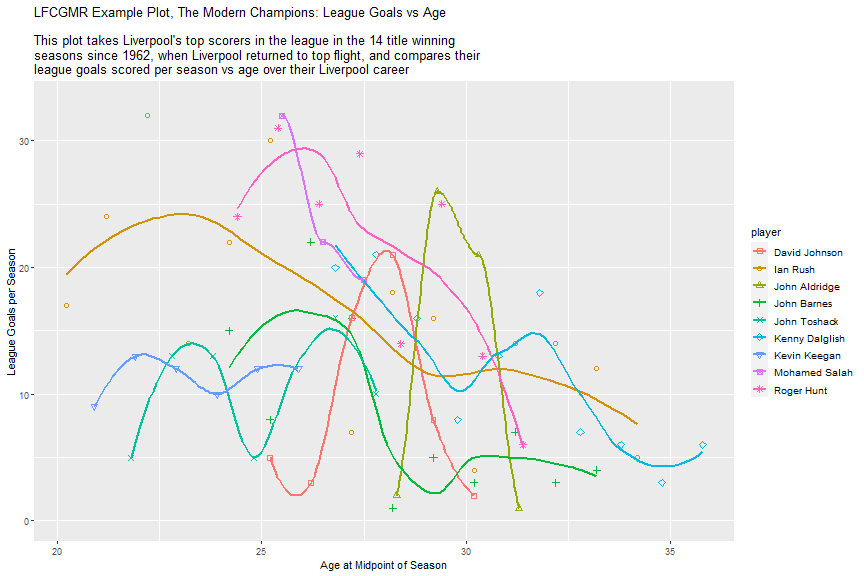

In [62]:
%%R -i dflfcgm -w 12 -h 8 -u in

# show the default plot, showing the champions (see below for more info on 'The Champions')
players = c()
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Plot a player with a single point

In [63]:
# plot a player with a single point
dflfcgm[dflfcgm.player=='Abel Xavier']

,season,player,league,position,age
256,2001-2002,Abel Xavier,1,Defender,29.1


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



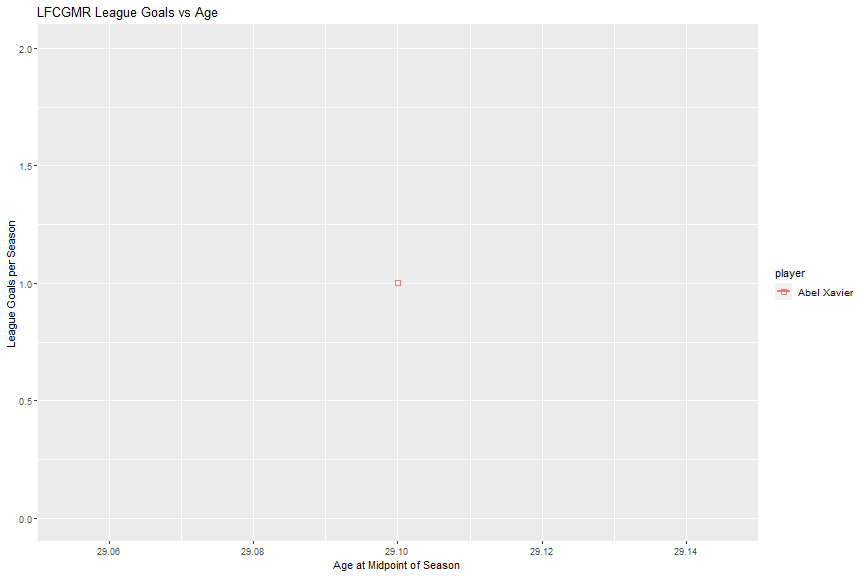

In [64]:
%%R -i dflfcgm -w 12 -h 8 -u in

# plot a player with a single point
players = c('Abel Xavier')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Plot a player with 2 points

In [65]:
# plot a player with 2 points
dflfcgm[dflfcgm.player=='Andy Carroll']

,season,player,league,position,age
122,2011-2012,Andy Carroll,4,Striker,23.0
141,2010-2011,Andy Carroll,2,Striker,22.0


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



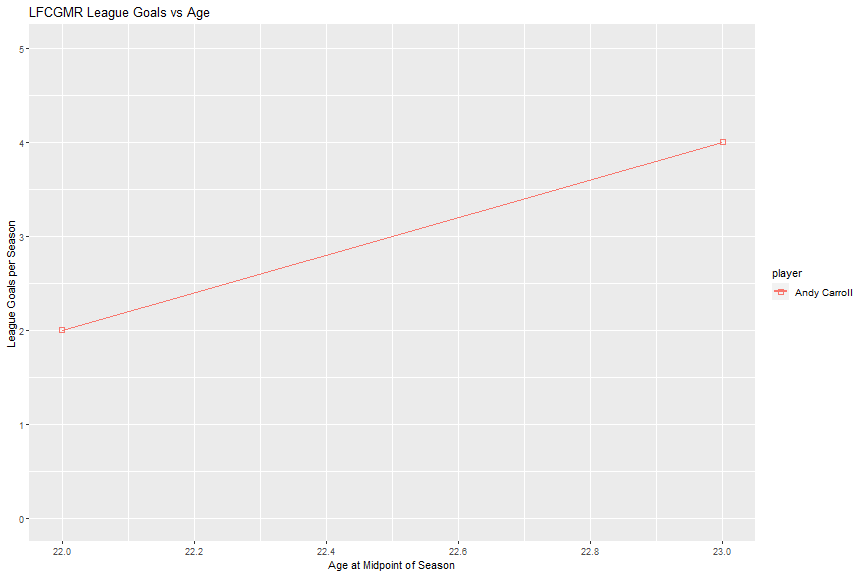

In [66]:
%%R -i dflfcgm -w 12 -h 8 -u in

# plot a player with 2 points
players = c('Andy Carroll')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

In [67]:
# plot a player with more than 2 points
dflfcgm[dflfcgm.player=='Luis Suarez']

,season,player,league,position,age
92,2013-2014,Luis Suarez,31,Striker,26.9
104,2012-2013,Luis Suarez,23,Striker,25.9
119,2011-2012,Luis Suarez,11,Striker,24.9
137,2010-2011,Luis Suarez,4,Striker,23.9


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



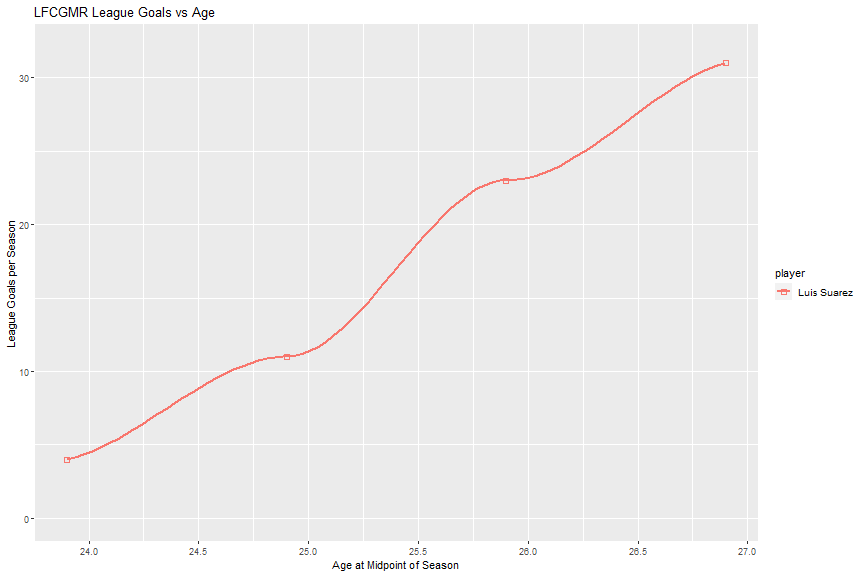

In [68]:
%%R -i dflfcgm -w 12 -h 8 -u in

# plot a player with more than 2 points
players = c('Luis Suarez')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Plot all 3, a player with 1, 2 and more than 2 points

In [69]:
# plot all 3
dflfcgm[dflfcgm.player.isin(['Abel Xavier', 'Andy Carroll', 'Luis Suarez'])]

,season,player,league,position,age
92,2013-2014,Luis Suarez,31,Striker,26.9
104,2012-2013,Luis Suarez,23,Striker,25.9
119,2011-2012,Luis Suarez,11,Striker,24.9
122,2011-2012,Andy Carroll,4,Striker,23.0
137,2010-2011,Luis Suarez,4,Striker,23.9
141,2010-2011,Andy Carroll,2,Striker,22.0
256,2001-2002,Abel Xavier,1,Defender,29.1


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



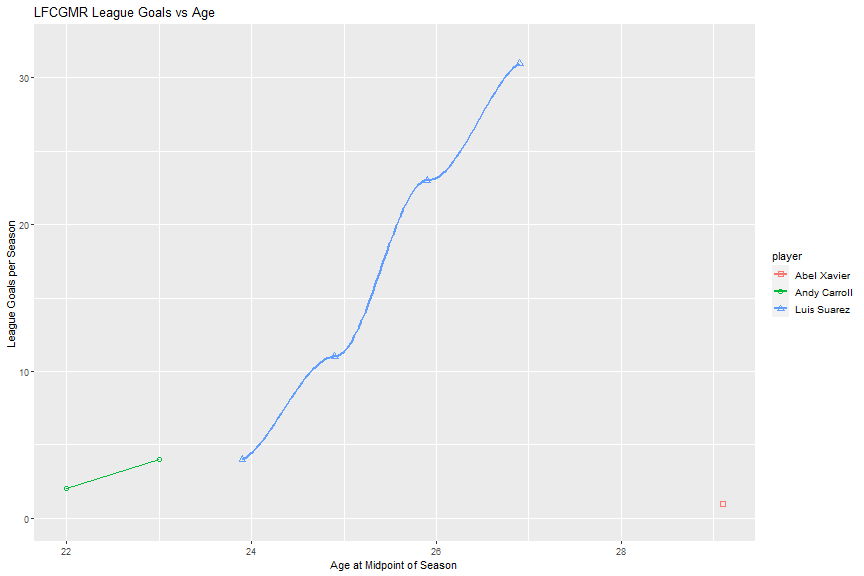

In [70]:
%%R -i dflfcgm -w 12 -h 8 -u in

# Plot all 3, a player with 1, 2 and more than 2 points
players = c('Abel Xavier', 'Andy Carroll', 'Luis Suarez')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

### Show some interesting LFC plots

New Scorer

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



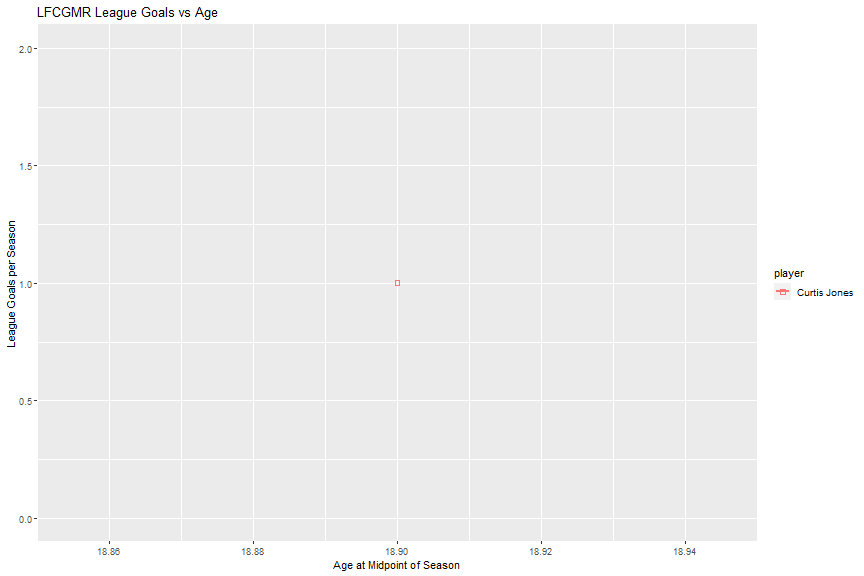

In [71]:
%%R -i dflfcgm -w 12 -h 8 -u in

# Show player who scored for first time in latest season (if any)
players = c('Curtis Jones')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Early Riser

In [72]:
# show all players scoring more than 20 goals when under 20 years old
dflfcgm[(dflfcgm.league >= 20) & 
        (dflfcgm.age < 20)]

,season,player,league,position,age
333,1994-1995,Robbie Fowler,25,Striker,19.7


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



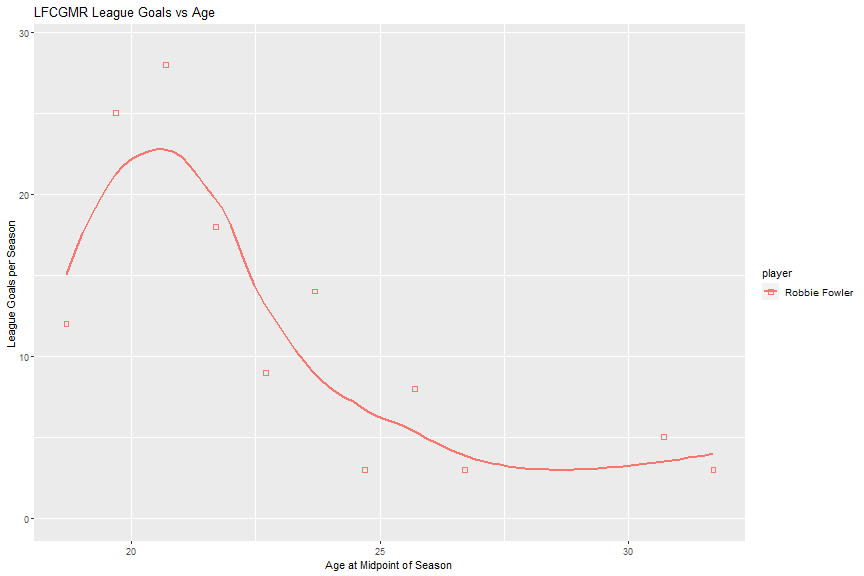

In [73]:
%%R -i dflfcgm -w 12 -h 8 -u in

# produce plot for player known as 'god'
players = c('Robbie Fowler')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Late Flourish

In [74]:
# show all players scoring more than 20 goals when over 30 years old
df_late = dflfcgm[(dflfcgm.league >= 20) & 
                  (dflfcgm.age > 30)]
players = list(df_late.player.values)
print(players)
df_late

['John Aldridge', 'Jack Balmer', 'Gordon Hodgson', 'Dick Forshaw', 'Ronald Orr']


,season,player,league,position,age
408,1988-1989,John Aldridge,21,Striker,30.3
815,1946-1947,Jack Balmer,24,Striker,30.9
862,1934-1935,Gordon Hodgson,27,Striker,30.7
970,1925-1926,Dick Forshaw,27,Striker,30.4
1115,1908-1909,Ronald Orr,20,Striker,32.4


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



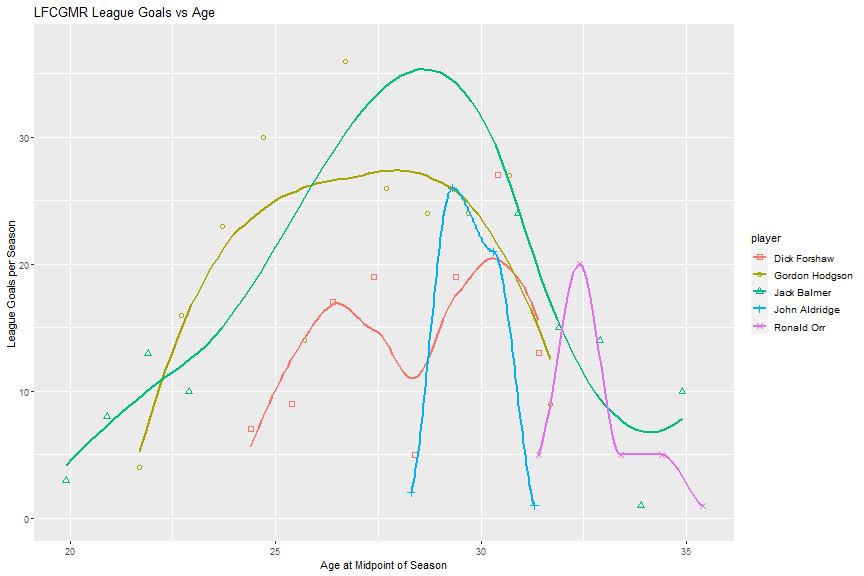

In [75]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('John Aldridge', 'Jack Balmer', 'Gordon Hodgson', 'Dick Forshaw', 'Ronald Orr')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

All time career top scorers

In [76]:
# show players scoring most league goals over their career
df_top = dflfcgm[['player', 'league']].groupby('player').sum()
df_top = df_top.sort_values('league', ascending=False).head(12)
df_top

,league
player,
Gordon Hodgson,233
Ian Rush,229
Roger Hunt,167
Harry Chambers,135
Robbie Fowler,128
Steven Gerrard,120
Kenny Dalglish,118
Michael Owen,118
Dick Forshaw,116


In [77]:
players = list(df_top[df_top.league >= 120].index.values)
print(players)

['Gordon Hodgson', 'Ian Rush', 'Roger Hunt', 'Harry Chambers', 'Robbie Fowler', 'Steven Gerrard']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



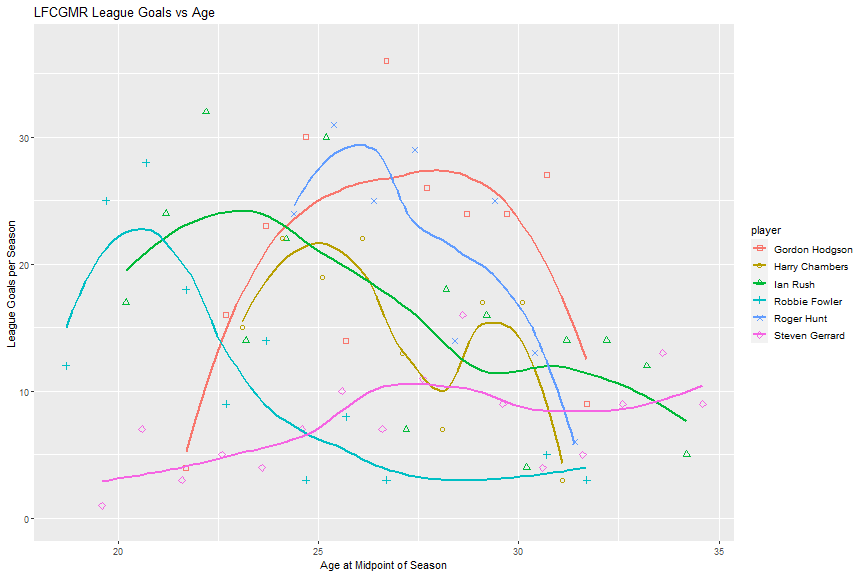

In [78]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Gordon Hodgson', 'Ian Rush', 'Roger Hunt', 'Harry Chambers', 'Robbie Fowler', 'Steven Gerrard')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Elite 30

In [79]:
# show players scoring >=30 league goals in a season
df_elite = dflfcgm[['season', 'player', 'league']].sort_values('league', ascending=False)
df_elite.head(10)

,season,player,league
909,1930-1931,Gordon Hodgson,36
465,1983-1984,Ian Rush,32
32,2017-2018,Mohamed Salah,32
714,1963-1964,Roger Hunt,31
92,2013-2014,Luis Suarez,31
1176,1902-1903,Sam Raybould,31
935,1928-1929,Gordon Hodgson,30
1105,1909-1910,Jack Parkinson,30
428,1986-1987,Ian Rush,30
687,1965-1966,Roger Hunt,29


In [80]:
players = list(df_elite[df_elite.league > 30].player.unique())
print(players)
#ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

['Gordon Hodgson', 'Ian Rush', 'Mohamed Salah', 'Roger Hunt', 'Luis Suarez', 'Sam Raybould']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



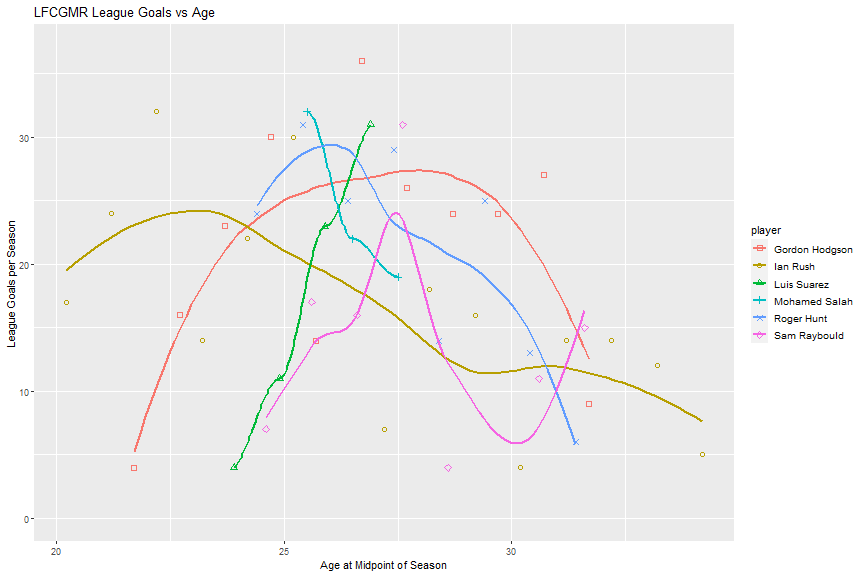

In [81]:
%%R -i dflfcgm players -w 12 -h 8 -u in

players = c('Gordon Hodgson', 'Ian Rush', 'Mohamed Salah', 'Sam Raybould', 'Luis Suarez', 'Roger Hunt')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

A Striking Trio
- For a discusson of Liverpool's best ever trio see Terry's blog [A Striking Trio](http://www.lfcsorted.com/2015/07/lfc-striking-trio.html)

In [82]:
# show best total for a striking trio in the league
df_trio = dflfcgm[['season', 'league']].groupby('season').head(3).groupby('season').sum()
df_trio.sort_values('league', ascending=False).head(10)

,league
season,
1963-1964,67
2013-2014,65
1930-1931,60
1909-1910,60
1946-1947,58
2017-2018,57
2018-2019,56
1934-1935,56
1987-1988,56


In [83]:
TOP_TRIO = ['1963-1964']
df_trio_players = dflfcgm[['season', 'player', 'league']]\
                                            [dflfcgm.season.isin(TOP_TRIO)].groupby('season').head(3)
players = list(df_trio_players.player.values)
print(players)
df_trio_players

['Roger Hunt', 'Ian St John', 'Alf Arrowsmith']


,season,player,league
714,1963-1964,Roger Hunt,31
715,1963-1964,Ian St John,21
716,1963-1964,Alf Arrowsmith,15


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



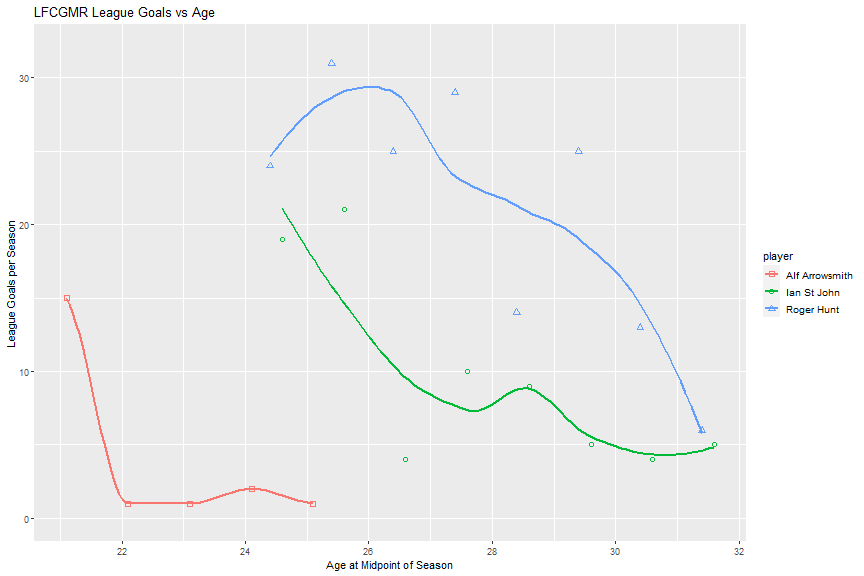

In [84]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Roger Hunt', 'Ian St John', 'Alf Arrowsmith')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

A Striking Duo

In [85]:
# show best total for a striking duo in the league
df_duo = dflfcgm[['season', 'league']].groupby('season').head(2).groupby('season').sum()
df_duo.sort_values('league', ascending=False).head(20)

,league
season,
1963-1964,52
2013-2014,52
1930-1931,50
1946-1947,48
1909-1910,48
2017-2018,47
1928-1929,46
1934-1935,46
1925-1926,44


In [86]:
TOP_DUO = ['1963-1964', '2013-2014']
df_duo_players = dflfcgm[['season', 'player', 'league']]\
                             [dflfcgm.season.isin(TOP_DUO)].groupby('season').head(2)
df_duo_players

,season,player,league
92,2013-2014,Luis Suarez,31
93,2013-2014,Daniel Sturridge,21
714,1963-1964,Roger Hunt,31
715,1963-1964,Ian St John,21


In [87]:
# plot first of TOP_DUO seasons
players = list(df_duo_players[df_duo_players.season == TOP_DUO[0]].player.values)
print(players)

['Roger Hunt', 'Ian St John']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



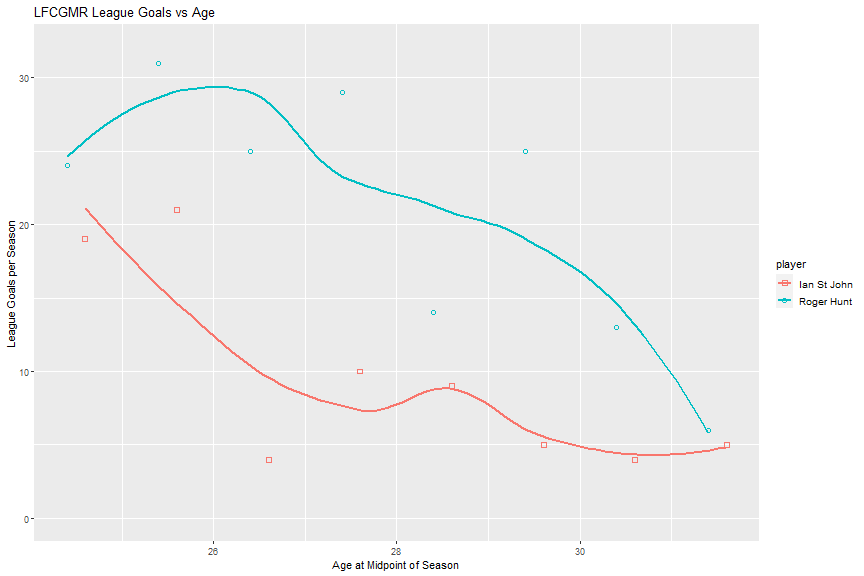

In [88]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Roger Hunt', 'Ian St John')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

In [89]:
# plot second of TOP_DUO seasons
players = list(df_duo_players[df_duo_players.season == TOP_DUO[1]].player.values)
print(players)

['Luis Suarez', 'Daniel Sturridge']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



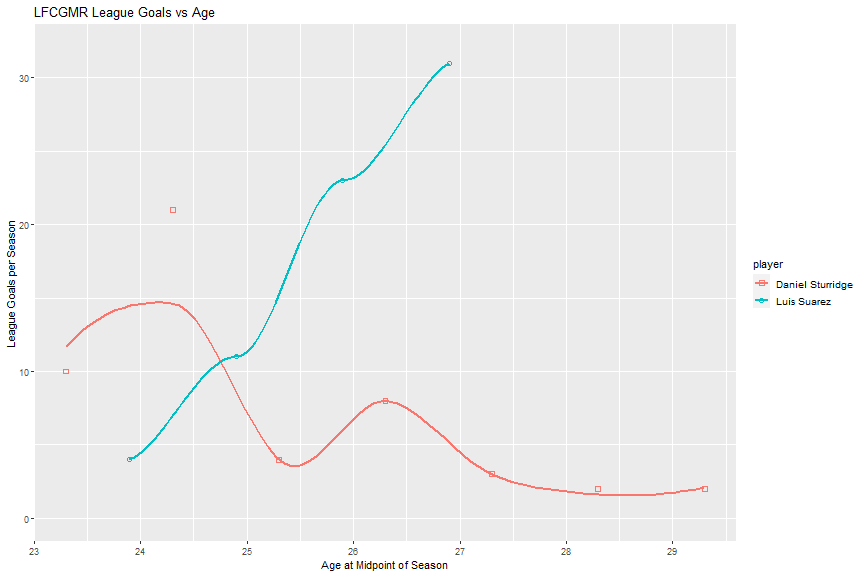

In [90]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Luis Suarez', 'Daniel Sturridge')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Performance of Liverpool players who went on to be managers

In [91]:
# produce list of managers - ref: http://www.lfchistory.net/Managers/
MANAGERS = ['William Barclay', 'Tom Watson', 'David Ashworth', 'Matt McQueen', 'George Patterson',\
    'George Kay', 'Don Welsh', 'Phil Taylor', 'Bill Shankly', 'Bob Paisley', 'Joe Fagan',\
    'Kenny Dalglish', 'Graeme Souness', 'Roy Evans', 'Gerard Houllier',\
    'Rafael Benitez', 'Roy Hodgson', 'Kenny Dalglish', 'Brendan Rodgers', 'Jurgen Klopp']
# excludes Ronnie Moran who was temporary manager in 1991

In [92]:
# produce list of players (who scored in more than 1 season at top level) who were managers
df_mgrs = dflfcgm[['player', 'league']][dflfcgm.player.isin(MANAGERS)]\
                                        .groupby('player').sum().sort_values('league', ascending=False)
df_mgrs

,league
player,
Kenny Dalglish,118
Graeme Souness,38
Phil Taylor,32
Bob Paisley,10


In [93]:
players = list(df_mgrs.index.values)
print(players)

['Kenny Dalglish', 'Graeme Souness', 'Phil Taylor', 'Bob Paisley']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



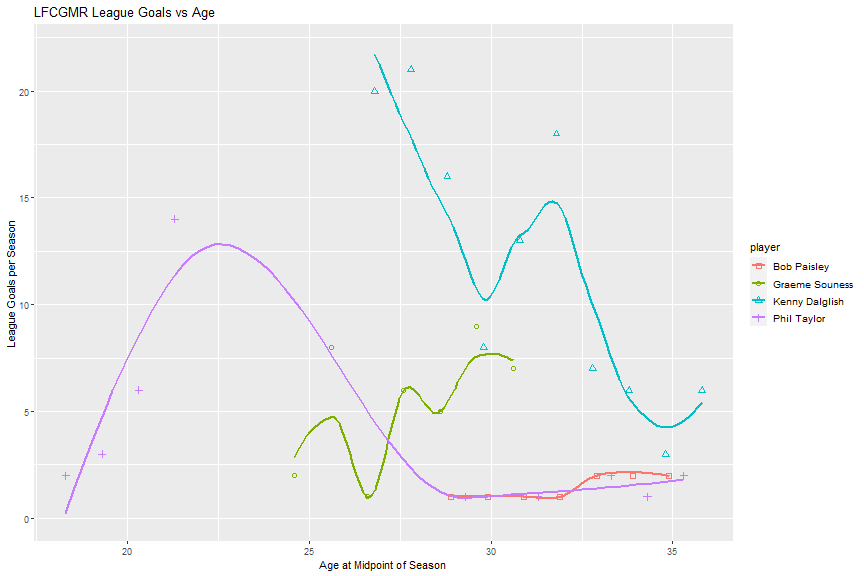

In [94]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Kenny Dalglish', 'Graeme Souness', 'Phil Taylor', 'Bob Paisley')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Top midfielders

In [95]:
# show midfielders who have scored more than 15 goals
df_mids = dflfcgm[(dflfcgm.position == 'Midfielder') &
                    (dflfcgm.league > 15)].sort_values('league', ascending=False)
df_mids

,season,player,league,position,age
760,1951-1952,Billy Liddell,19,Midfielder,30.0
453,1984-1985,John Wark,18,Midfielder,27.4
478,1982-1983,Kenny Dalglish,18,Midfielder,31.8
783,1949-1950,Billy Liddell,17,Midfielder,28.0
899,1931-1932,Gordon Gunson,17,Midfielder,27.5
156,2008-2009,Steven Gerrard,16,Midfielder,28.6
387,1990-1991,John Barnes,16,Midfielder,27.2
936,1928-1929,Dick Edmed,16,Midfielder,24.9


In [96]:
players = list(df_mids.sort_values('league', ascending=False).player.unique())
print(len(players), players)

7 ['Billy Liddell', 'John Wark', 'Kenny Dalglish', 'Gordon Gunson', 'Steven Gerrard', 'John Barnes', 'Dick Edmed']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



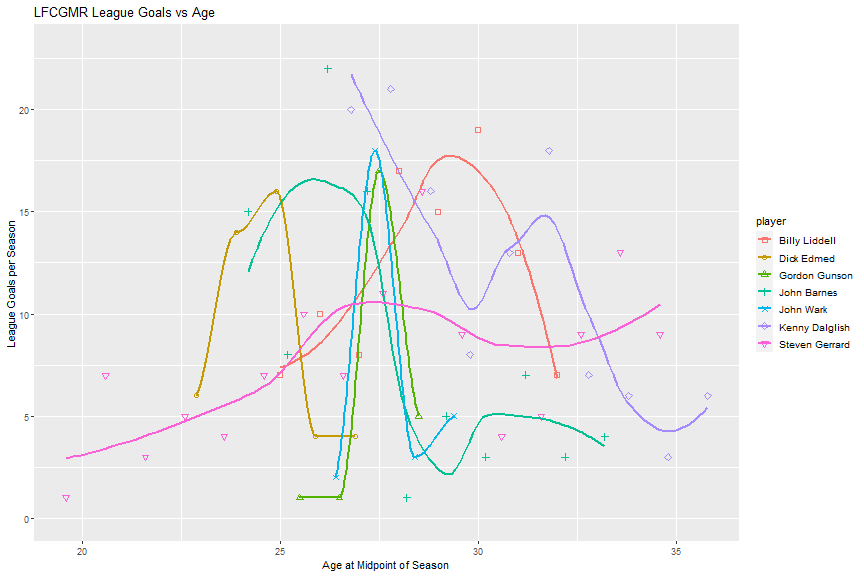

In [97]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Billy Liddell', 'John Wark', 'Kenny Dalglish', 'Gordon Gunson', 'Steven Gerrard', 'John Barnes', 'Dick Edmed')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Top Defenders

In [98]:
# show defenders who have scored more than 6 goals
df_defs = dflfcgm[(dflfcgm.position == 'Defender') &
                  (dflfcgm.league > 6)].sort_values('league', ascending=False)
df_defs

,season,player,league,position,age
638,1969-1970,Chris Lawler,10,Defender,26.2
480,1982-1983,Phil Neal,8,Defender,31.9
53,2016-2017,James Milner,7,Defender,31.0
96,2013-2014,Martin Skrtel,7,Defender,29.0
248,2001-2002,John Arne Riise,7,Defender,21.3
552,1976-1977,Phil Neal,7,Defender,25.9


In [99]:
players = list(df_defs.sort_values('league', ascending=False).player.unique())
print(len(players), players)

5 ['Chris Lawler', 'Phil Neal', 'James Milner', 'Martin Skrtel', 'John Arne Riise']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



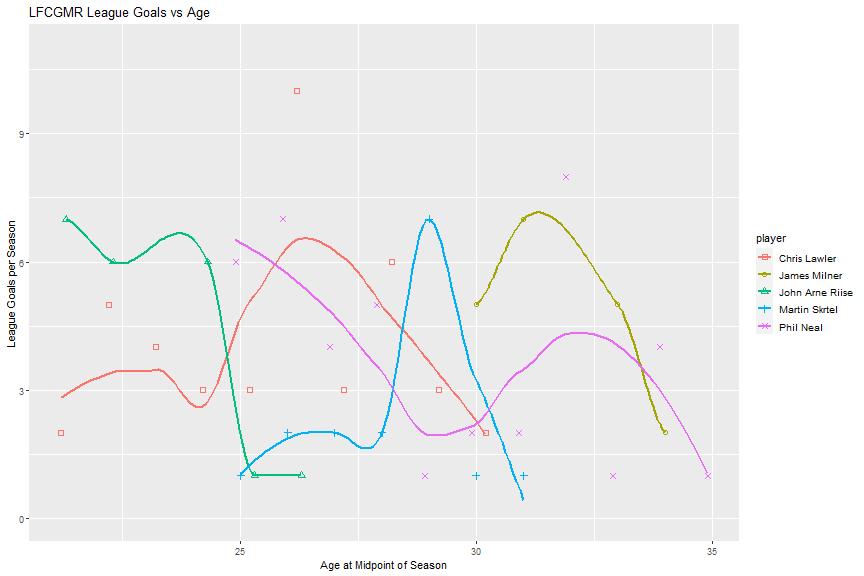

In [100]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Chris Lawler', 'Phil Neal', 'James Milner', 'Martin Skrtel', 'John Arne Riise')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Peak Performance

In [101]:
# show player with top score in a season, Gordon Hodgson
top_player = dflfcgm[dflfcgm.league == max(dflfcgm.league)]
top_player

,season,player,league,position,age
909,1930-1931,Gordon Hodgson,36,Striker,26.7


In [102]:
players = list(top_player.player.values)
print(players)

['Gordon Hodgson']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



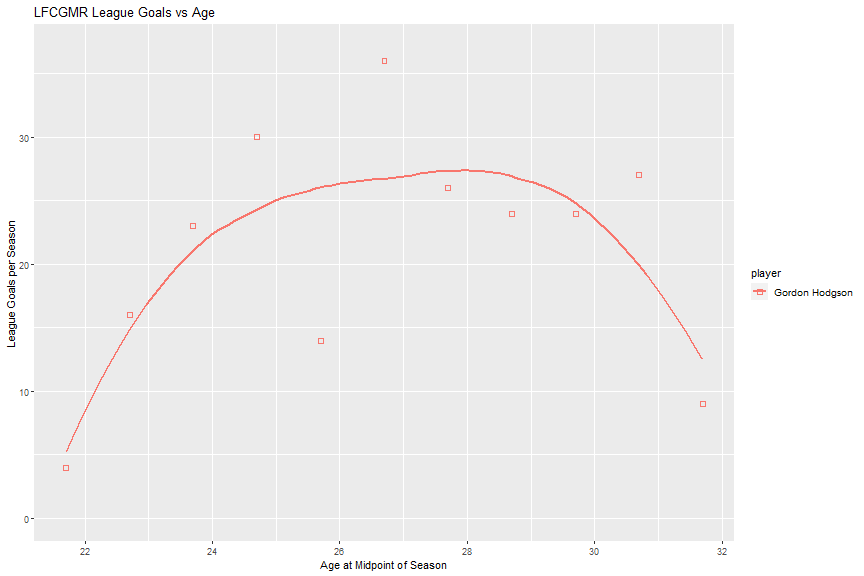

In [103]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Gordon Hodgson')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Rocket Men

Show the players scored over 50  goals in 3 or more consecutive seasons, with a rising number of goals each season.

In [104]:
# create dataframe ordered by player and season
df = dflfcgm.groupby(['player', 'season']).sum()
df.head(12)

league   age
player          season                 
Abel Xavier     2001-2002       1  29.1
Abraham Hartley 1897-1898       1  25.9
Adam Lallana    2014-2015       5  26.6
                2015-2016       4  27.6
                2016-2017       8  28.6
                2019-2020       1  31.6
Alan A'Court    1952-1953       2  18.3
                1953-1954       3  19.3
                1962-1963       2  28.3
Alan Arnell     1953-1954       1  20.1
Alan Hansen     1978-1979       1  23.5
                1979-1980       4  24.5

In [105]:
def linefit(x, y):
    """"Return gradient and intercept of straight line of best fit for given x and y arrays."""
    gradient, intercept = np.polyfit(x, y, 1)
    return gradient, intercept

[-1  0  1  2]
[ 8  6  8 14]
2.0 8.0


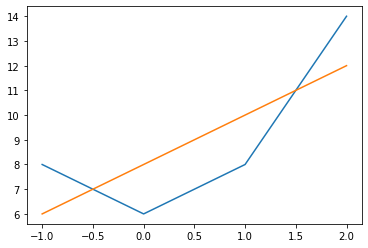

In [106]:
# test linefit()
# using y = 2x^2 + 6
x=np.array([-1, 0, 1, 2])
print(x)
y=2*x*x + 6
print(y)
print(plt.plot(x, y))
gradient, intercept = linefit(x, y)
print(np.round(gradient, 1), np.round(intercept, 1))
print(plt.plot(x, gradient*x + intercept))

In [107]:
# Show the players scored over 50 goals in 3 or more consecutive seasons, with a rising number of goals each season.
MIN_SEASONS = 3
MIN_TOTAL_GOALS = 50
p_prev = None # previous player
l_prev = None # previous league goals
Lg = [] # List of consecutive goals
La = [] # List of consecutive ages
Ls = [] # List of consecutive seasons

# iterate through dataframe 
# for each row of (player, season) (league goals, age)
for (p, s), (l, a) in df.iterrows():
    #print (p,s,l,a)
    if p != p_prev:
        # new player, so check previous
        if len(Lg) >= MIN_SEASONS and sum(Lg) >= MIN_TOTAL_GOALS:
            grad, intercept = linefit(np.array(range(len(Lg))), np.array(Lg))
            print('Rocket man: {}, goals={}, start_season={}, start_age={}, goals={}, grad={}'\
                                .format(p_prev, Lg, Ls[0], La[0], sum(Lg), np.round(grad, 2)))
            
        #print('new p', p)
        l_prev = None
        Lg = []
        La = []
        Ls = []
        
    #print(p, s, l, a) #player, season, league, age
    #print(l, l_prev, Lg)
    if (l_prev == None) or (l >= l_prev):
        #print('\t', l, 'greater than', l_prev, Lg)
        Lg.append(l)
        La.append(a)
        Ls.append(s)
    else:
        if len(Lg) >= MIN_SEASONS and sum(Lg) >= MIN_TOTAL_GOALS:
            grad, intercept = linefit(np.array(range(len(Lg))), np.array(Lg))
            print('Rocket man: {}, goals={}, start_season={}, start_age={}, goals={}, grad={}'\
                  .format(p_prev, Lg, Ls[0], La[0], sum(Lg), np.round(grad, 2)))
        Lg = [l]
        La = [a]
        Ls = [s]
    
    l_prev = l
    p_prev = p
            

Rocket man: Berry Nieuwenhuys, goals=[9.0, 10.0, 10.0, 13.0, 13.0, 14.0], start_season=1933-1934, start_age=22.2, goals=69.0, grad=1.06
Rocket man: Dick Forshaw, goals=[7.0, 9.0, 17.0, 19.0], start_season=1919-1920, start_age=24.4, goals=52.0, grad=4.4
Rocket man: Dick Forshaw, goals=[5.0, 19.0, 27.0], start_season=1923-1924, start_age=28.4, goals=51.0, grad=11.0
Rocket man: Gordon Hodgson, goals=[4.0, 16.0, 23.0, 30.0], start_season=1925-1926, start_age=21.7, goals=73.0, grad=8.5
Rocket man: Gordon Hodgson, goals=[24.0, 24.0, 27.0], start_season=1932-1933, start_age=28.7, goals=75.0, grad=1.5
Rocket man: Ian Rush, goals=[17.0, 24.0, 32.0], start_season=1981-1982, start_age=20.2, goals=73.0, grad=7.5
Rocket man: Ian Rush, goals=[14.0, 22.0, 30.0], start_season=1984-1985, start_age=23.2, goals=66.0, grad=8.0
Rocket man: Luis Suarez, goals=[4.0, 11.0, 23.0, 31.0], start_season=2010-2011, start_age=23.9, goals=69.0, grad=9.3
Rocket man: Michael Owen, goals=[11.0, 16.0, 19.0, 19.0], start_

Top 5 Rocket Men (sorted by gradient of line of best fit) are
- Dick Forshaw, 11
- Luis Suarez, 9.3
- Gordon Hodgson, 8.5
- Ian Rush, 8.0
- Robbie Fowler, 8.0

In [108]:
# show example graph of the rocket portion of the players career e.g. Robbie Fowler
p = 'Robbie Fowler'
Lg = [12.0, 25.0, 28.0]
dfp = dflfcgm[(dflfcgm.player == p) &
              (dflfcgm.league.isin(Lg))]
print(dfp)
#print ggplot_age_vs_lgoals(dfp, [p])

        season         player  league position   age
323  1995-1996  Robbie Fowler      28  Striker  20.7
333  1994-1995  Robbie Fowler      25  Striker  19.7
343  1993-1994  Robbie Fowler      12  Striker  18.7


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



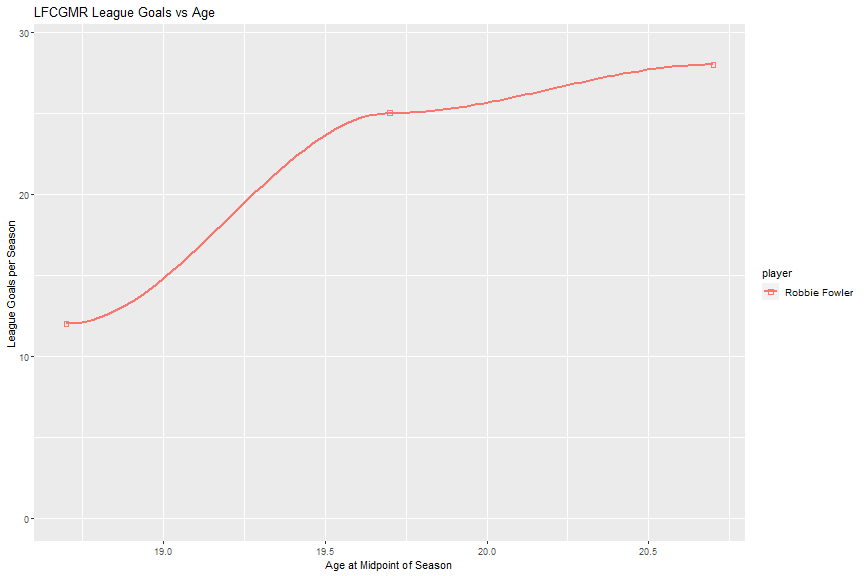

In [109]:
%%R -i dfp -w 12 -h 8 -u in

players = c('Robbie Fowler')
plt <- ggplot_age_vs_lgoals(dfp, players)
print(plt)

Striking Nostalgia

In [110]:
# Just a few of my early favourites
players = ['Kevin Keegan', 'Kenny Dalglish', 'Steve Heighway']

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



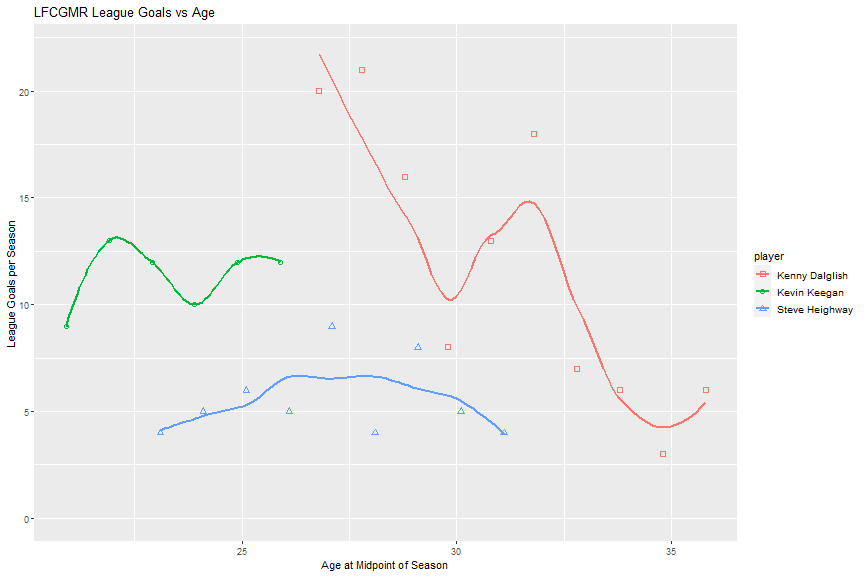

In [111]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Kevin Keegan', 'Kenny Dalglish', 'Steve Heighway')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Highest scoring midfielders over career

In [112]:
df = dflfcgm[(dflfcgm.position == 'Midfielder')]\
                            .groupby('player').sum()
print(df[df.league > 50].sort_values('league', ascending=False)['league'])
players = df[df.league > 50].sort_values('league', ascending=False).index.unique()
print(len(players), list(players))

player
Steven Gerrard       120
Billy Liddell         96
Berry Nieuwenhuys     74
Arthur Goddard        65
Jack Cox              62
John Barnes           62
Terry McDermott       54
Name: league, dtype: int64
7 ['Steven Gerrard', 'Billy Liddell', 'Berry Nieuwenhuys', 'Arthur Goddard', 'Jack Cox', 'John Barnes', 'Terry McDermott']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



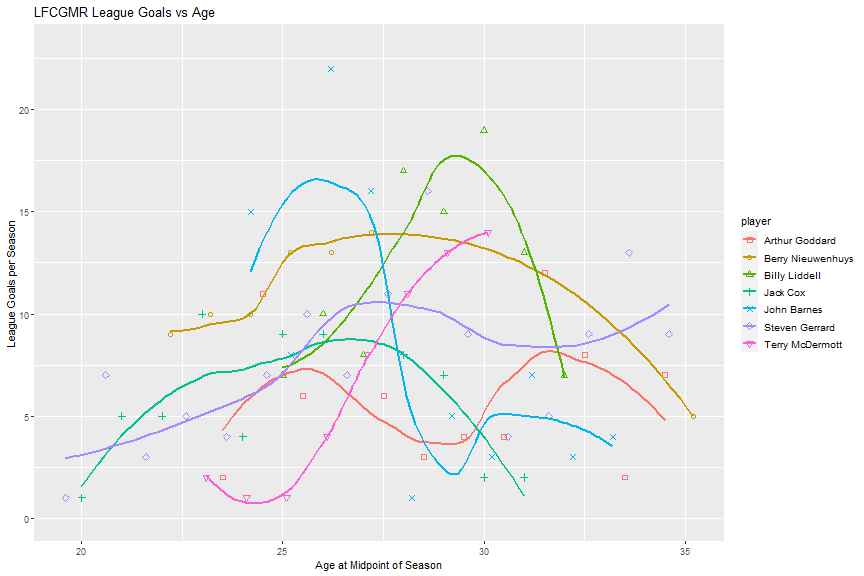

In [113]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Steven Gerrard', 'Billy Liddell', 'Berry Nieuwenhuys', 'Arthur Goddard', 'Jack Cox', 'John Barnes', 'Terry McDermott')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Highest scoring defenders over career

In [114]:
df = dflfcgm[(dflfcgm.position == 'Defender')]\
                            .groupby('player').sum()
print(df[df.league > 20].sort_values('league', ascending=False)['league'])
players = df[df.league > 20].sort_values('league', ascending=False).index.unique()
print(len(players), list(players))

player
Chris Lawler        41
Phil Neal           41
Tommy Smith         36
Donald Mackinlay    28
Steve Nicol         23
Sami Hyypia         22
John Arne Riise     21
Name: league, dtype: int64
7 ['Chris Lawler', 'Phil Neal', 'Tommy Smith', 'Donald Mackinlay', 'Steve Nicol', 'Sami Hyypia', 'John Arne Riise']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



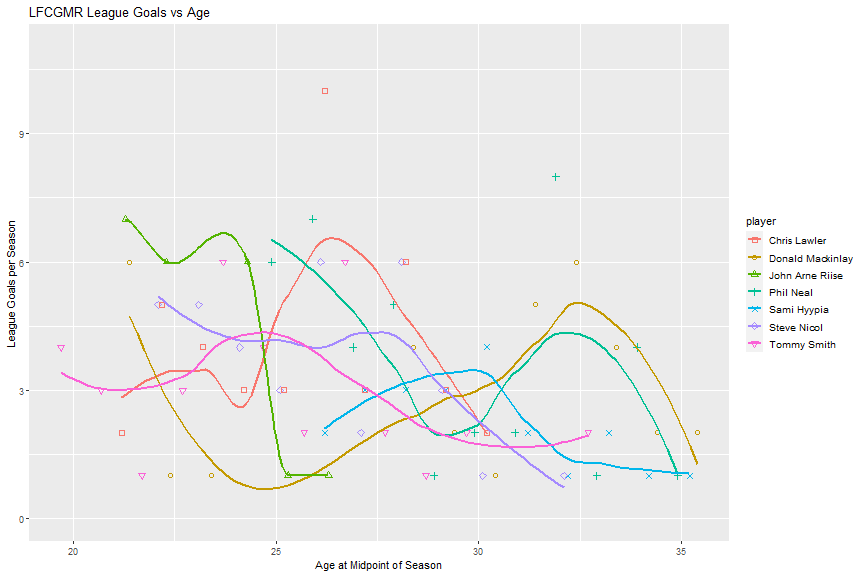

In [115]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Chris Lawler', 'Phil Neal', 'Tommy Smith', 'Donald Mackinlay', 'Steve Nicol', 'Sami Hyypia', 'John Arne Riise')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

The Champions

This plot shows the goalscoring performance over their Liverpool career of 
arguably the most important 8 players, those who scored most goals in the 
19 title winning seasons

In [116]:
# create list of seasons when LFC were champions
CHAMPS = ['1900-1901', '1905-1906', '1921-1922', '1922-1923', '1946-1947', '1963-1964',\
          '1965-1966', '1972-1973', '1975-1976', '1976-1977', '1978-1979', '1979-1980',\
          '1981-1982', '1982-1983', '1983-1984', '1985-1986', '1987-1988', '1989-1990', '2019-2020']
print(len(CHAMPS))

19


In [117]:
# show total goals over career in title winning teams
df_champs = dflfcgm[dflfcgm.season.isin(CHAMPS)][['league', 'player']].groupby('player').sum()\
                            .sort_values('league', ascending=False).head(12)
df_champs

,league
player,
Ian Rush,113
Kenny Dalglish,78
Roger Hunt,60
David Johnson,44
Harry Chambers,41
John Toshack,39
Kevin Keegan,37
John Barnes,37
Dick Forshaw,36


In [118]:
# plot top 8
players = list(df_champs.index.values[:8])
print(players)

['Ian Rush', 'Kenny Dalglish', 'Roger Hunt', 'David Johnson', 'Harry Chambers', 'John Toshack', 'Kevin Keegan', 'John Barnes']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



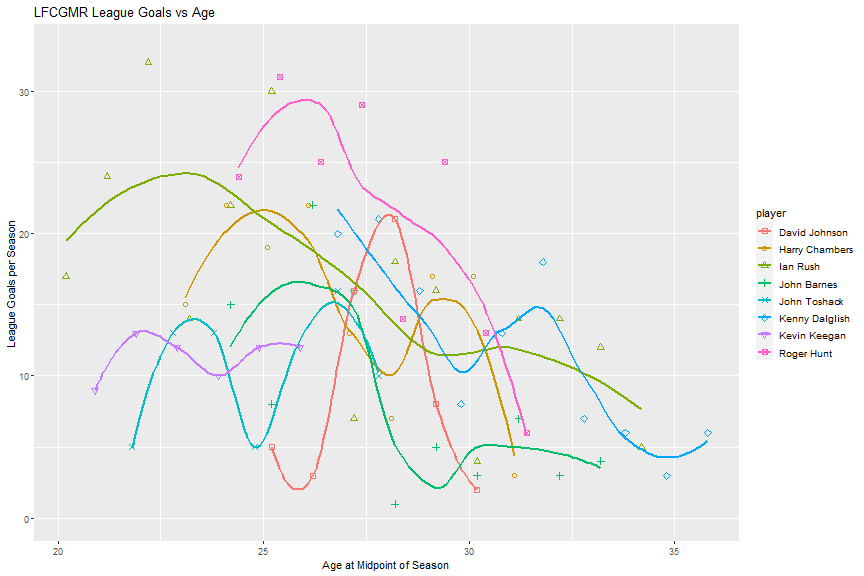

In [119]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Ian Rush', 'Kenny Dalglish', 'Roger Hunt', 'David Johnson', 'Harry Chambers', 'John Toshack', 'John Barnes', 'Kevin Keegan')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

This was the original default example plot in lfcgm v2 (when we only had 18 titles!)

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



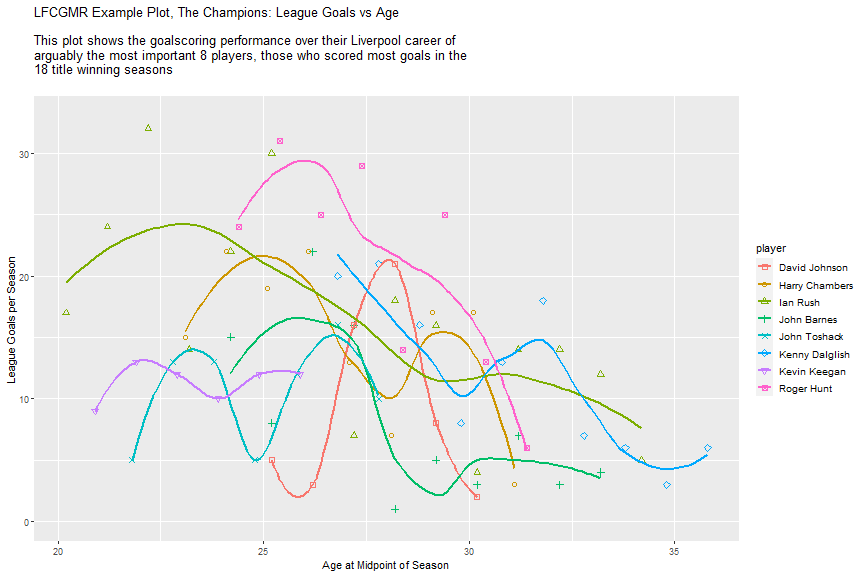

In [120]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c()
plt <- ggplot_age_vs_lgoals_v2(dflfcgm, players)
print(plt)

In [121]:
# show highest scorers in a title winning season
dflfcgm[dflfcgm.season.isin(CHAMPS)].sort_values('league', ascending=False).head(10)

,season,player,league,position,age
465,1983-1984,Ian Rush,32,Striker,22.2
714,1963-1964,Roger Hunt,31,Striker,25.4
687,1965-1966,Roger Hunt,29,Striker,27.4
418,1987-1988,John Aldridge,26,Striker,29.3
477,1982-1983,Ian Rush,24,Striker,21.2
814,1946-1947,Albert Stubbins,24,Striker,27.5
1149,1905-1906,Joe Hewitt,24,Striker,24.7
815,1946-1947,Jack Balmer,24,Striker,30.9
439,1985-1986,Ian Rush,22,Striker,24.2
396,1989-1990,John Barnes,22,Striker,26.2


In [122]:
dflfc_scorers_tl.columns

Index(['season', 'player', 'league'], dtype='object')

In [123]:
dflfc_scorers_tl.head()

,season,player,league
1452,2019-2020,Mohamed Salah,19
1453,2019-2020,Sadio Mane,18
1454,2019-2020,Roberto Firmino,9
1455,2019-2020,Virgil Van Dijk,5
1456,2019-2020,Alex Oxlade-Chamberlain,4


In [124]:
champs_top_scorers = set()
count = 0
for season in CHAMPS:
    count += 1
    print(f"title#: {count}, season: {season}")
    max_goals =  dflfc_scorers_tl[(dflfc_scorers_tl.season == season)].league.max()
    #print(max_goals)
    top_scorers = dflfc_scorers_tl[(dflfc_scorers_tl.season == season) & 
                           (dflfc_scorers_tl.league == max_goals)].player.values
    print(f"\ttop scorer(s): {', '.join(top_scorers)} with {max_goals} goals")
    for top_scorer in top_scorers:
        champs_top_scorers.add(top_scorer)

print('\n', count, champs_top_scorers)

title#: 1, season: 1900-1901
	top scorer(s): Sam Raybould with 17 goals
title#: 2, season: 1905-1906
	top scorer(s): Joe Hewitt with 24 goals
title#: 3, season: 1921-1922
	top scorer(s): Harry Chambers with 19 goals
title#: 4, season: 1922-1923
	top scorer(s): Harry Chambers with 22 goals
title#: 5, season: 1946-1947
	top scorer(s): Albert Stubbins, Jack Balmer with 24 goals
title#: 6, season: 1963-1964
	top scorer(s): Roger Hunt with 31 goals
title#: 7, season: 1965-1966
	top scorer(s): Roger Hunt with 29 goals
title#: 8, season: 1972-1973
	top scorer(s): Kevin Keegan, John Toshack with 13 goals
title#: 9, season: 1975-1976
	top scorer(s): John Toshack with 16 goals
title#: 10, season: 1976-1977
	top scorer(s): Kevin Keegan with 12 goals
title#: 11, season: 1978-1979
	top scorer(s): Kenny Dalglish with 21 goals
title#: 12, season: 1979-1980
	top scorer(s): David Johnson with 21 goals
title#: 13, season: 1981-1982
	top scorer(s): Ian Rush with 17 goals
title#: 14, season: 1982-1983
	to

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



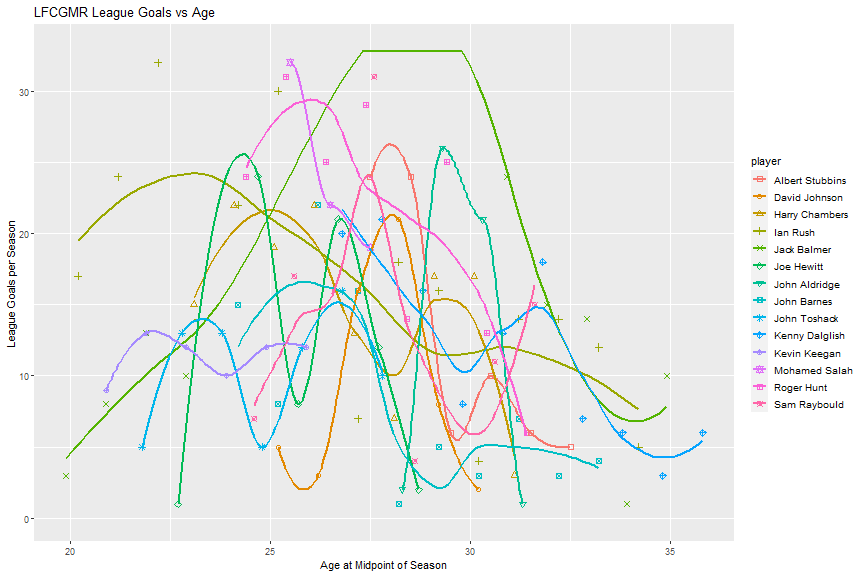

In [125]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Kevin Keegan', 'Harry Chambers', 'Albert Stubbins', 'Jack Balmer', 'Sam Raybould', 'Roger Hunt', 'Ian Rush', 'John Aldridge', 'David Johnson', 'Kenny Dalglish', 'John Toshack', 'John Barnes', 'Mohamed Salah', 'Joe Hewitt')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

In [126]:
# show top scorers in title winning seasons in the modern era (post-1962 when Liverpool return to top flight)
champs_top_scorers = set()
count = 0
for season in CHAMPS:
    if season < '1962':
        continue
    count += 1
    print(f"modern title#: {count}, season: {season}")
    max_goals =  dflfc_scorers_tl[(dflfc_scorers_tl.season == season)].league.max()
    #print(max_goals)
    top_scorers = dflfc_scorers_tl[(dflfc_scorers_tl.season == season) & 
                           (dflfc_scorers_tl.league == max_goals)].player.values
    print('\t', ', '.join(top_scorers), max_goals)
    for top_scorer in top_scorers:
        champs_top_scorers.add(top_scorer)

print('\n', count, sorted(champs_top_scorers))

modern title#: 1, season: 1963-1964
	 Roger Hunt 31
modern title#: 2, season: 1965-1966
	 Roger Hunt 29
modern title#: 3, season: 1972-1973
	 Kevin Keegan, John Toshack 13
modern title#: 4, season: 1975-1976
	 John Toshack 16
modern title#: 5, season: 1976-1977
	 Kevin Keegan 12
modern title#: 6, season: 1978-1979
	 Kenny Dalglish 21
modern title#: 7, season: 1979-1980
	 David Johnson 21
modern title#: 8, season: 1981-1982
	 Ian Rush 17
modern title#: 9, season: 1982-1983
	 Ian Rush 24
modern title#: 10, season: 1983-1984
	 Ian Rush 32
modern title#: 11, season: 1985-1986
	 Ian Rush 22
modern title#: 12, season: 1987-1988
	 John Aldridge 26
modern title#: 13, season: 1989-1990
	 John Barnes 22
modern title#: 14, season: 2019-2020
	 Mohamed Salah 19

 14 ['David Johnson', 'Ian Rush', 'John Aldridge', 'John Barnes', 'John Toshack', 'Kenny Dalglish', 'Kevin Keegan', 'Mohamed Salah', 'Roger Hunt']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



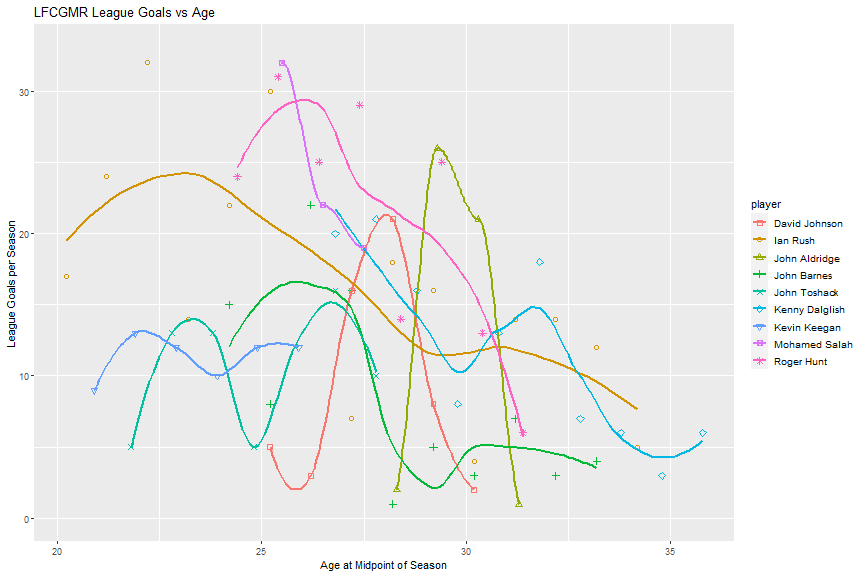

In [127]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('David Johnson', 'Ian Rush', 'John Aldridge', 'John Barnes', 'John Toshack', 'Kenny Dalglish', 'Kevin Keegan', 'Mohamed Salah', 'Roger Hunt')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

This is the new default example plot in v3 of lfcgm

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



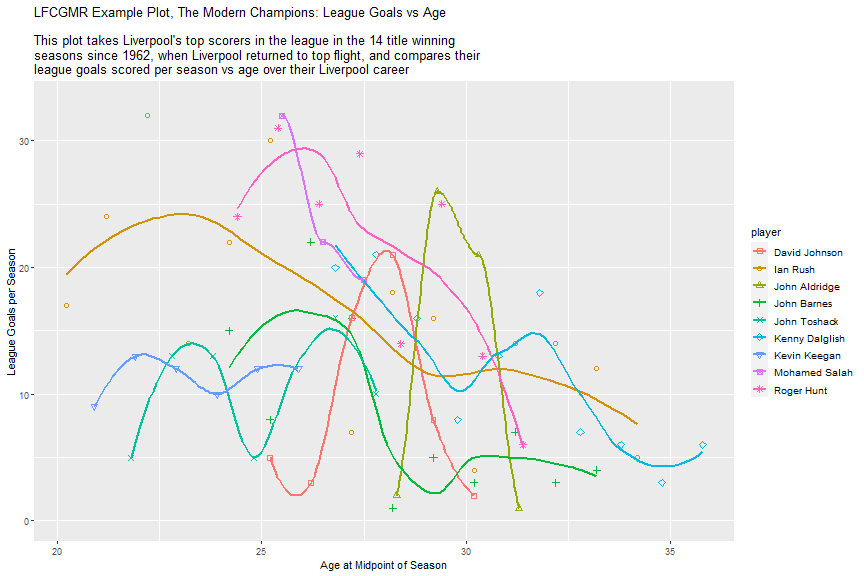

In [128]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c()
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

European Cup Winning Team, May 1977

In [129]:
players = ['Ray Clemence', 'Phil Neal', 'Joey Jones', 'Tommy Smith',
           'Ray Kennedy', 'Emlyn Hughes', 'Kevin Keegan', 'Jimmy Case',
           'Steve Heighway', 'Ian Callaghan', 'Terry McDermott']
print(players)

['Ray Clemence', 'Phil Neal', 'Joey Jones', 'Tommy Smith', 'Ray Kennedy', 'Emlyn Hughes', 'Kevin Keegan', 'Jimmy Case', 'Steve Heighway', 'Ian Callaghan', 'Terry McDermott']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



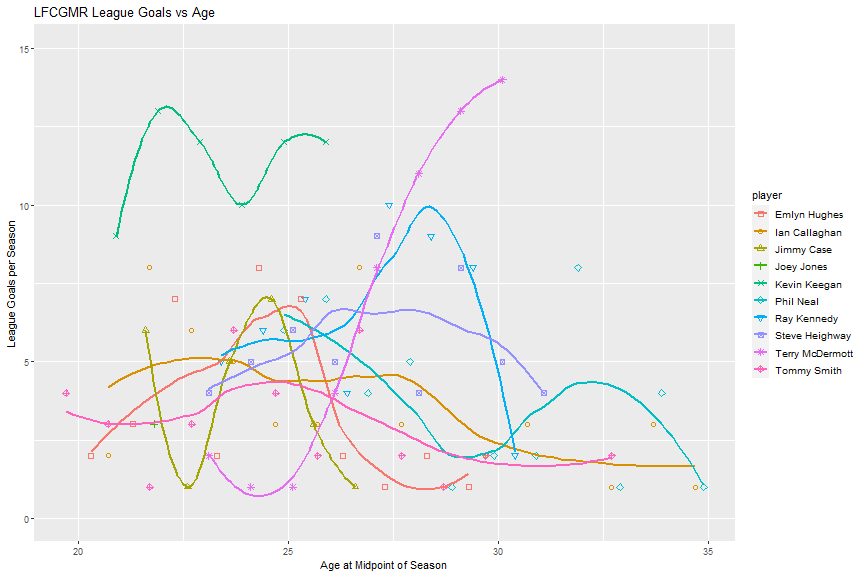

In [130]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Ray Clemence', 'Phil Neal', 'Joey Jones', 'Tommy Smith', 'Ray Kennedy', 'Emlyn Hughes', 'Kevin Keegan', 'Jimmy Case', 'Steve Heighway', 'Ian Callaghan', 'Terry McDermott')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

Best goals per game

In [131]:
dflfc_scorers_tl_pos_age_apps.head()

,season,player,league,position,age,lgapp,GPG
0,2019-2020,Mohamed Salah,19,Striker,27.5,34,0.559
1,2019-2020,Sadio Mane,18,Striker,27.7,35,0.514
2,2019-2020,Roberto Firmino,9,Striker,28.2,38,0.237
3,2019-2020,Virgil Van Dijk,5,Defender,28.5,38,0.132
4,2019-2020,Alex Oxlade-Chamberlain,4,Midfielder,26.4,30,0.133


In [132]:
# show best GPG per season where appearance > 10
dflfc_scorers_tl_pos_age_apps[dflfc_scorers_tl_pos_age_apps.lgapp > 10].sort_values('GPG', ascending=False).head(15)

,season,player,league,position,age,lgapp,GPG
1105,1909-1910,Jack Parkinson,30,Striker,26.3,31,0.968
92,2013-2014,Luis Suarez,31,Striker,26.9,33,0.939
1176,1902-1903,Sam Raybould,31,Striker,27.6,33,0.939
909,1930-1931,Gordon Hodgson,36,Striker,26.7,40,0.900
32,2017-2018,Mohamed Salah,32,Striker,25.5,36,0.889
970,1925-1926,Dick Forshaw,27,Striker,30.4,32,0.844
1045,1914-1915,Fred Pagnam,24,Striker,23.3,29,0.828
145,2009-2010,Fernando Torres,18,Striker,25.8,22,0.818
862,1934-1935,Gordon Hodgson,27,Striker,30.7,34,0.794
935,1928-1929,Gordon Hodgson,30,Striker,24.7,38,0.789


In [133]:
# show best Career GPG (CGPG) per career where appearance > 50
df_gpg = dflfc_scorers_tl_pos_age_apps[['player', 'league', 'lgapp']].groupby('player').sum()
df_gpg['CGPG'] = (df_gpg.league/df_gpg.lgapp).round(3) # career goals per game
df_gpg['CMPG'] = (df_gpg.lgapp*90/df_gpg.league).round(3) # career minutes per goal (assume all apps = 90 mins)
df_gpg[df_gpg.lgapp > 50].sort_values('CGPG', ascending=False).head(12)

,league,lgapp,CGPG,CMPG
player,,,,
Mohamed Salah,73,108,0.676,133.151
Gordon Hodgson,233,358,0.651,138.283
Fernando Torres,65,102,0.637,141.231
Luis Suarez,69,110,0.627,143.478
Jimmy Smith,38,61,0.623,144.474
John Aldridge,50,83,0.602,149.400
Tom Reid,30,51,0.588,153.000
Jack Parkinson,103,178,0.579,155.534
Roger Hunt,167,295,0.566,158.982


In [134]:
# plot top 6 goal scorers with best Career GPG
players = list(df_gpg[df_gpg.lgapp > 50].sort_values('CGPG', ascending=False).head(6).index.values)
print(players)

['Mohamed Salah', 'Gordon Hodgson', 'Fernando Torres', 'Luis Suarez', 'Jimmy Smith', 'John Aldridge']


R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



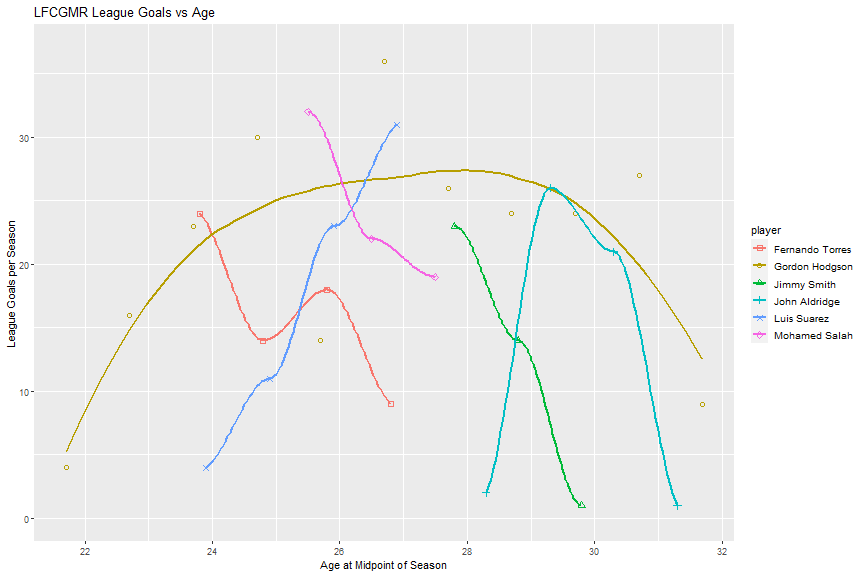

In [135]:
%%R -i dflfcgm -w 12 -h 8 -u in

players = c('Mohamed Salah', 'Gordon Hodgson', 'Fernando Torres', 'Luis Suarez', 'Jimmy Smith', 'John Aldridge')
plt <- ggplot_age_vs_lgoals(dflfcgm, players)
print(plt)

## Note on the variable number of games per season

Note that the number of league games has varied over the top level seasons.

In [136]:
# show number of different total games
print(dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])].PLD.unique())

[30 34 38 42 40]


In [137]:
# show number of seasons for each total
dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])][['PLD', 'Season']].groupby('PLD').count()

,Season
PLD,
30,3
34,6
38,38
40,1
42,57


In [138]:
# show the seasons for each total
dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])][['PLD', 'Season']]\
                        .groupby('PLD')['Season'].apply(lambda x: ','.join(x))

PLD
30                        1894-1895,1896-1897,1897-1898
34    1898-1899,1899-1900,1900-1901,1901-1902,1902-1...
38    1905-1906,1906-1907,1907-1908,1908-1909,1909-1...
40                                            1987-1988
42    1919-1920,1920-1921,1921-1922,1922-1923,1923-1...
Name: Season, dtype: object

## lfcgmR App

### Building and Deploying the lfcgmR App

The lfcgmR interactive web app is built using R Shiny and published using their cloud platform.

Useful reference material:
+ How to develop a shiny app [https://shiny.rstudio.com/](https://shiny.rstudio.com/).

### Running the App

The app is available at [lfcgmr.lfcsorted.com](http://lfcgmr.lfcsorted.com) and [terrydolan.shinyapps.io/lfcgmR](https://terrydolan.shinyapps.io/lfcgmR/).

### App Source Code

The lfcgmR source code is available on github at [lfcgmR github repo](https://github.com/terrydolan/lfcgmR).

The main files are:
+ ui.R: user interface definition.
+ server.R: server definition, with main plot and table functions.
+ global.R: global definition e.g. version.
+ about.html: description of the app.
+ lfcgmR.ipynb: this notebook.

## App Data

The LFC Goal Machine app uses the following data files:
+ data/lfcgm_app_dropdown.csv (used to build the dropdown list of players)
+ data/lfc_scorers_tl_pos_age.csv (used to build the pandas dataframe of LFC scorers in top level league)

The data structure of these files is described in this notebook. However the data is not in the lfcgm github repository because the data is owned by [lfchistory.net](http://www.lfchistory.net).

In [139]:
# report how long notebook ran
nb_run_time = dt.datetime.now() - nb_start_time
print(f"notebook ran for {nb_run_time.total_seconds():.1f} seconds" + "\n")

notebook ran for 19.1 seconds



In [140]:
print("reached final cell")

reached final cell
